In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [2]:
# %% create the image
def create_img(k, m, n, step):
    img = np.random.randint(0, step, (k, m,n))
    return img

# %% Finding the min rectangle which warp the triangle
def min_rectangle(r0, r1, r2, theta):
    theta = theta / 180 * np.pi
    x0 = 0
    y0 = 0
    alpha = np.arccos((r2**2 - r1**2 - r0**2) / (2*r0*r1))
    y2 = - r0 * np.cos(theta)
    x2 = r0 * np.sin(theta)
    beta = 2 * np.pi - theta - alpha
    x1 = - r1 * np.sin(beta)
    y1 = - r1 * np.cos(beta)
    return [[x0, y0], [x1, y1], [x2, y2]]

# %% Generate Mask
def generate_mask(x):
    width = np.max((np.abs(x[0,0] - x[1,0]), 
                     np.abs(x[2,0] - x[1,0]),
                     np.abs(x[0,0] - x[2,0])))
    height = np.max((np.abs(x[0,1] - x[1,1]), 
                     np.abs(x[2,1] - x[1,1]),
                     np.abs(x[0,1] - x[2,1])))
    mask = np.zeros([np.int(height)+1, np.int(width)+1])
    ## SHIFT COR
    start_point = np.min(x, axis=0)
    shift_point = x - start_point.reshape([1,2])
    shift_point = np.around(shift_point)
    shift_point = shift_point.astype(np.int)
    mask[shift_point[:,1], shift_point[:,0]] = 1
    return mask

def bilinear(ind, mask_):
    x = ind[0]
    y = ind[1]
    x_0 = np.floor(x)
    y_0 = np.floor(y)
    a = 0
    b = 0
    if x != x_0:
        a = (y - y_0) / (y_0 + 1 - y)
    if y != y_0:
        b = (x - x_0) / (x_0 + 1 - x)
    c = 1 / (a * b + a + b + 1)
    x_0 = x_0.astype(np.int)
    y_0 = y_0.astype(np.int)
    mask_[y_0,x_0] += c
    mask_[y_0,x_0+1] += b * c
    mask_[y_0+1,x_0] += a * c
    mask_[y_0+1,x_0+1] += a * b * c
    return mask_

def generate_bilinear_mask(x):
    ## SHIFT COR
    start_point = np.min(x, axis=0)
    start_point = np.floor(start_point)
    shift_point = x - start_point
    
    width = np.max((np.abs(shift_point[0,0]), 
                     np.abs(shift_point[2,0]),
                     np.abs(shift_point[1,0])))
    height = np.max((np.abs(shift_point[0,1]), 
                     np.abs(shift_point[2,1]),
                     np.abs(shift_point[1,1])))
    mask = np.zeros([(np.ceil(height)+1).astype(np.int), (np.ceil(width)+1).astype(np.int)])
    
    mask[np.int(shift_point[0,1]), np.int(shift_point[0,0])] = 1
    mask = bilinear(shift_point[1,:], mask)
    mask = bilinear(shift_point[2,:], mask)
    return mask

 


In [3]:
def triangle_center(a, b):
    img = np.zeros([a, a])
    k1 = a / 2 * (1 - np.sqrt(3)) + b / (np.sqrt(3))
    k2 = a / 2 * (1 + np.sqrt(3)) + b / (np.sqrt(3))
    for i in range(int(np.round(a / 2 - b / 2)), int(np.ceil(a / 2 + b / 2))):
        for j in range(int(np.round(a / 2 - (b / (2 * np.sqrt(3))))), int(np.ceil(a / 2 + (b / (np.sqrt(3)))))):
            if(i * np.sqrt(3) + k1 - j >= 0 and i * (-np.sqrt(3)) + k2- j >= 0):
                img[j, i] = 1
    return img

def triangle_filter(a, b):
    img = np.zeros([a, a])
    img[int(np.round(a / 2 - b / 2)), int(np.round(a / 2 - (b / (2 * np.sqrt(3)))))] = 1
    img[int(np.round(a / 2 + b / 2)), int(np.round(a / 2 - (b / (2 * np.sqrt(3)))))] = 1
    img[int(a/2), int(np.ceil(a / 2 + (b / (np.sqrt(3)))))] = 1
#     k1 = a / 2 * (1 - np.sqrt(3)) + b / (np.sqrt(3))
#     k2 = a / 2 * (1 + np.sqrt(3)) + b / (np.sqrt(3))
#     for i in range(int(np.round(a / 2 - b / 2)), int(np.ceil(a / 2 + b / 2))):
#         for j in range(int(np.round(a / 2 - (b / (2 * np.sqrt(3))))), int(np.ceil(a / 2 + (b / (np.sqrt(3)))))):
#             if(i * np.sqrt(3) + k1 - j >= 0 and i * (-np.sqrt(3)) + k2- j >= 0):
#                 img[j, i] = 1
    return img.T

def triangle_filter_line(a, b):
    img = np.zeros([a, a])
    k1 = a / 2 * (1 - np.sqrt(3)) + b / (np.sqrt(3))
    k2 = a / 2 * (1 + np.sqrt(3)) + b / (np.sqrt(3))
    for i in range(int(np.round(a / 2 - b / 2)), int(np.ceil(a / 2 + b / 2))):
        for j in range(int(np.round(a / 2 - (b / (2 * np.sqrt(3))))), int(np.ceil(a / 2 + (b / (np.sqrt(3)))))):
            if(np.abs(i * np.sqrt(3) + k1 - j) / 2 < 0.5 or np.abs(i * (-np.sqrt(3)) + k2- j) / 2 < 0.5 or \
               np.abs(j - int(np.round(a / 2 - (b / (2 * np.sqrt(3))))))<=0.5):
                img[j, i] = 1
    img[int(np.round(a / 2 - (b / (2 * np.sqrt(3))))), int(np.round(a / 2 - b / 2))] = 1
    img[int(np.round(a / 2 - (b / (2 * np.sqrt(3))))), int(np.round(a / 2 + b / 2))] = 1
    img[int(np.ceil(a / 2 + (b / (np.sqrt(3))))), int(a/2)] = 1
    return img


In [65]:
# %% main function
step = 2
size = (10, 10)
n = 30
[x1, x2, x3, x4] = [np.sqrt(2), np.sqrt(2), 2, 45]
a = create_img(n, size[0], size[1], step)
b = min_rectangle(x1, x2, x3, x4)
b = np.asarray(b)
d = generate_mask(b)

11.0


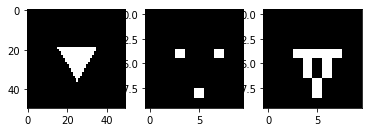

In [11]:
a = triangle_center(50, 20)
size = a.shape
d = triangle_filter(10, 4)
e = triangle_filter_line(10, 4)
print(np.sum(e))
f, axarr = plt.subplots(1,3)
axarr[0].imshow(a, cmap='gray')
axarr[1].imshow(d, cmap='gray')
axarr[2].imshow(e, cmap='gray')
plt.show()

In [12]:
# %% convert to pytorch code
aa = np.rot90(np.rot90(a)).copy()
inputs = torch.from_numpy(aa.reshape([1, 1, size[0], size[1]]))
# inputs = torch.from_numpy(a.reshape([1, 1, size[0], size[1]]))
inputs = inputs.type(torch.FloatTensor)
inputs = Variable(inputs)
weights = torch.from_numpy(d.reshape([1,1,d.shape[0], d.shape[1]]))
weights = weights.type(torch.FloatTensor)
weights = Variable(weights)
bias = Variable(torch.tensor([-2.0]))
outputs = F.conv_transpose2d(weights, inputs, bias, padding=0)
# outputs = F.conv2d(inputs, weights, bias, padding=5)
# print(outputs.size())
outputs = F.relu(outputs)
outputs = torch.mean(outputs, dim=(1,2,3))
outputs = torch.mean(outputs)
print(outputs)

tensor(0.0327)


In [13]:
outputs.requires_grad = False
weights.requires_grad = False
bias.requires_grad = False
I = Variable(torch.rand([1, 1, size[0], size[1]]), requires_grad=True)
init_I = I.detach().data
# I = Variable(I, requires_grad=True)
for i in range(10000):
    out = F.conv_transpose2d(weights, I, bias, padding=0, stride=1)
    out = F.relu(out)
    loss1 = ((out.mean()-outputs)**2).mean()
    loss2 = (I - torch.square(I)).mean()
    print(loss1, loss2)
    loss = loss1 + loss2*0.001
    grads = torch.autograd.grad(loss, I)
    print(loss)
    with torch.no_grad():
        if I.grad is None:
            I.grad = grads[0].detach()
        else:
            I.grad.fill_(grads[0].detach())
    I = I - 1000 * I.grad
    I = torch.clamp(I, 0, 1)

tensor(0.0001, grad_fn=<MeanBackward0>) tensor(0.1682, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(6.3448e-05, grad_fn=<MeanBackward0>) tensor(0.1669, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(3.6085e-05, grad_fn=<MeanBackward0>) tensor(0.1659, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(2.0154e-05, grad_fn=<MeanBackward0>) tensor(0.1652, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.1279e-05, grad_fn=<MeanBackward0>) tensor(0.1646, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.2912e-06, grad_fn=<MeanBackward0>) tensor(0.1641, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(3.4984e-06, grad_fn=<MeanBackward0>) tensor(0.1637, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.9123e-06, grad_fn=<MeanBackward0>) tensor(0.1634, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.0171e-06, g

/opt/anaconda3/envs/py3_ml/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


tensor(4.3466e-08, grad_fn=<MeanBackward0>) tensor(0.1518, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3375e-08, grad_fn=<MeanBackward0>) tensor(0.1517, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3387e-08, grad_fn=<MeanBackward0>) tensor(0.1516, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3249e-08, grad_fn=<MeanBackward0>) tensor(0.1515, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3299e-08, grad_fn=<MeanBackward0>) tensor(0.1514, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3268e-08, grad_fn=<MeanBackward0>) tensor(0.1513, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3204e-08, grad_fn=<MeanBackward0>) tensor(0.1512, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3127e-08, grad_fn=<MeanBackward0>) tensor(0.1511, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.3121e-0

tensor(4.0763e-08, grad_fn=<MeanBackward0>) tensor(0.1417, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.0896e-08, grad_fn=<MeanBackward0>) tensor(0.1416, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.0916e-08, grad_fn=<MeanBackward0>) tensor(0.1415, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.1075e-08, grad_fn=<MeanBackward0>) tensor(0.1414, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.1018e-08, grad_fn=<MeanBackward0>) tensor(0.1413, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.1151e-08, grad_fn=<MeanBackward0>) tensor(0.1412, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.1059e-08, grad_fn=<MeanBackward0>) tensor(0.1411, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.1216e-08, grad_fn=<MeanBackward0>) tensor(0.1410, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.1257e-0

tensor(3.8767e-08, grad_fn=<MeanBackward0>) tensor(0.1324, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8576e-08, grad_fn=<MeanBackward0>) tensor(0.1324, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8789e-08, grad_fn=<MeanBackward0>) tensor(0.1323, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8566e-08, grad_fn=<MeanBackward0>) tensor(0.1322, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8751e-08, grad_fn=<MeanBackward0>) tensor(0.1321, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8359e-08, grad_fn=<MeanBackward0>) tensor(0.1320, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8585e-08, grad_fn=<MeanBackward0>) tensor(0.1319, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8565e-08, grad_fn=<MeanBackward0>) tensor(0.1318, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.8717e-0

tensor(3.8040e-08, grad_fn=<MeanBackward0>) tensor(0.1239, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7653e-08, grad_fn=<MeanBackward0>) tensor(0.1238, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7550e-08, grad_fn=<MeanBackward0>) tensor(0.1237, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7686e-08, grad_fn=<MeanBackward0>) tensor(0.1237, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7570e-08, grad_fn=<MeanBackward0>) tensor(0.1236, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7809e-08, grad_fn=<MeanBackward0>) tensor(0.1235, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7650e-08, grad_fn=<MeanBackward0>) tensor(0.1234, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7852e-08, grad_fn=<MeanBackward0>) tensor(0.1233, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7702e-0

tensor(3.5829e-08, grad_fn=<MeanBackward0>) tensor(0.1161, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5676e-08, grad_fn=<MeanBackward0>) tensor(0.1160, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5595e-08, grad_fn=<MeanBackward0>) tensor(0.1159, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5657e-08, grad_fn=<MeanBackward0>) tensor(0.1159, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5399e-08, grad_fn=<MeanBackward0>) tensor(0.1158, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5278e-08, grad_fn=<MeanBackward0>) tensor(0.1157, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5346e-08, grad_fn=<MeanBackward0>) tensor(0.1156, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5319e-08, grad_fn=<MeanBackward0>) tensor(0.1155, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5332e-0

tensor(3.2436e-08, grad_fn=<MeanBackward0>) tensor(0.1095, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2528e-08, grad_fn=<MeanBackward0>) tensor(0.1094, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2460e-08, grad_fn=<MeanBackward0>) tensor(0.1094, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2446e-08, grad_fn=<MeanBackward0>) tensor(0.1093, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2397e-08, grad_fn=<MeanBackward0>) tensor(0.1092, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2410e-08, grad_fn=<MeanBackward0>) tensor(0.1091, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2312e-08, grad_fn=<MeanBackward0>) tensor(0.1091, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2504e-08, grad_fn=<MeanBackward0>) tensor(0.1090, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.2394e-0

tensor(3.0144e-08, grad_fn=<MeanBackward0>) tensor(0.1040, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9872e-08, grad_fn=<MeanBackward0>) tensor(0.1039, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9916e-08, grad_fn=<MeanBackward0>) tensor(0.1038, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9882e-08, grad_fn=<MeanBackward0>) tensor(0.1038, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9810e-08, grad_fn=<MeanBackward0>) tensor(0.1037, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9929e-08, grad_fn=<MeanBackward0>) tensor(0.1036, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9963e-08, grad_fn=<MeanBackward0>) tensor(0.1035, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9846e-08, grad_fn=<MeanBackward0>) tensor(0.1035, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9989e-0

tensor(9.8570e-05, grad_fn=<AddBackward0>)
tensor(2.8396e-08, grad_fn=<MeanBackward0>) tensor(0.0985, grad_fn=<MeanBackward0>)
tensor(9.8502e-05, grad_fn=<AddBackward0>)
tensor(2.8499e-08, grad_fn=<MeanBackward0>) tensor(0.0984, grad_fn=<MeanBackward0>)
tensor(9.8433e-05, grad_fn=<AddBackward0>)
tensor(2.8412e-08, grad_fn=<MeanBackward0>) tensor(0.0983, grad_fn=<MeanBackward0>)
tensor(9.8365e-05, grad_fn=<AddBackward0>)
tensor(2.8433e-08, grad_fn=<MeanBackward0>) tensor(0.0983, grad_fn=<MeanBackward0>)
tensor(9.8296e-05, grad_fn=<AddBackward0>)
tensor(2.8529e-08, grad_fn=<MeanBackward0>) tensor(0.0982, grad_fn=<MeanBackward0>)
tensor(9.8228e-05, grad_fn=<AddBackward0>)
tensor(2.8342e-08, grad_fn=<MeanBackward0>) tensor(0.0981, grad_fn=<MeanBackward0>)
tensor(9.8160e-05, grad_fn=<AddBackward0>)
tensor(2.8298e-08, grad_fn=<MeanBackward0>) tensor(0.0981, grad_fn=<MeanBackward0>)
tensor(9.8092e-05, grad_fn=<AddBackward0>)
tensor(2.8263e-08, grad_fn=<MeanBackward0>) tensor(0.0980, grad_fn=<

tensor(2.5509e-08, grad_fn=<MeanBackward0>) tensor(0.0934, grad_fn=<MeanBackward0>)
tensor(9.3463e-05, grad_fn=<AddBackward0>)
tensor(2.5631e-08, grad_fn=<MeanBackward0>) tensor(0.0934, grad_fn=<MeanBackward0>)
tensor(9.3398e-05, grad_fn=<AddBackward0>)
tensor(2.5580e-08, grad_fn=<MeanBackward0>) tensor(0.0933, grad_fn=<MeanBackward0>)
tensor(9.3333e-05, grad_fn=<AddBackward0>)
tensor(2.5624e-08, grad_fn=<MeanBackward0>) tensor(0.0932, grad_fn=<MeanBackward0>)
tensor(9.3268e-05, grad_fn=<AddBackward0>)
tensor(2.5684e-08, grad_fn=<MeanBackward0>) tensor(0.0932, grad_fn=<MeanBackward0>)
tensor(9.3203e-05, grad_fn=<AddBackward0>)
tensor(2.5722e-08, grad_fn=<MeanBackward0>) tensor(0.0931, grad_fn=<MeanBackward0>)
tensor(9.3138e-05, grad_fn=<AddBackward0>)
tensor(2.5753e-08, grad_fn=<MeanBackward0>) tensor(0.0930, grad_fn=<MeanBackward0>)
tensor(9.3073e-05, grad_fn=<AddBackward0>)
tensor(2.5778e-08, grad_fn=<MeanBackward0>) tensor(0.0930, grad_fn=<MeanBackward0>)
tensor(9.3008e-05, grad_fn=

tensor(2.3329e-08, grad_fn=<MeanBackward0>) tensor(0.0889, grad_fn=<MeanBackward0>)
tensor(8.8903e-05, grad_fn=<AddBackward0>)
tensor(2.3416e-08, grad_fn=<MeanBackward0>) tensor(0.0888, grad_fn=<MeanBackward0>)
tensor(8.8842e-05, grad_fn=<AddBackward0>)
tensor(2.3376e-08, grad_fn=<MeanBackward0>) tensor(0.0888, grad_fn=<MeanBackward0>)
tensor(8.8780e-05, grad_fn=<AddBackward0>)
tensor(2.3346e-08, grad_fn=<MeanBackward0>) tensor(0.0887, grad_fn=<MeanBackward0>)
tensor(8.8718e-05, grad_fn=<AddBackward0>)
tensor(2.3314e-08, grad_fn=<MeanBackward0>) tensor(0.0886, grad_fn=<MeanBackward0>)
tensor(8.8656e-05, grad_fn=<AddBackward0>)
tensor(2.3260e-08, grad_fn=<MeanBackward0>) tensor(0.0886, grad_fn=<MeanBackward0>)
tensor(8.8594e-05, grad_fn=<AddBackward0>)
tensor(2.3243e-08, grad_fn=<MeanBackward0>) tensor(0.0885, grad_fn=<MeanBackward0>)
tensor(8.8532e-05, grad_fn=<AddBackward0>)
tensor(2.3179e-08, grad_fn=<MeanBackward0>) tensor(0.0884, grad_fn=<MeanBackward0>)
tensor(8.8469e-05, grad_fn=

tensor(2.1046e-08, grad_fn=<MeanBackward0>) tensor(0.0843, grad_fn=<MeanBackward0>)
tensor(8.4335e-05, grad_fn=<AddBackward0>)
tensor(2.0998e-08, grad_fn=<MeanBackward0>) tensor(0.0843, grad_fn=<MeanBackward0>)
tensor(8.4273e-05, grad_fn=<AddBackward0>)
tensor(2.0950e-08, grad_fn=<MeanBackward0>) tensor(0.0842, grad_fn=<MeanBackward0>)
tensor(8.4212e-05, grad_fn=<AddBackward0>)
tensor(2.0916e-08, grad_fn=<MeanBackward0>) tensor(0.0841, grad_fn=<MeanBackward0>)
tensor(8.4151e-05, grad_fn=<AddBackward0>)
tensor(2.0905e-08, grad_fn=<MeanBackward0>) tensor(0.0841, grad_fn=<MeanBackward0>)
tensor(8.4089e-05, grad_fn=<AddBackward0>)
tensor(2.0949e-08, grad_fn=<MeanBackward0>) tensor(0.0840, grad_fn=<MeanBackward0>)
tensor(8.4028e-05, grad_fn=<AddBackward0>)
tensor(2.0992e-08, grad_fn=<MeanBackward0>) tensor(0.0839, grad_fn=<MeanBackward0>)
tensor(8.3967e-05, grad_fn=<AddBackward0>)
tensor(2.1005e-08, grad_fn=<MeanBackward0>) tensor(0.0839, grad_fn=<MeanBackward0>)
tensor(8.3905e-05, grad_fn=

tensor(2.0809e-08, grad_fn=<MeanBackward0>) tensor(0.0767, grad_fn=<MeanBackward0>)
tensor(7.6726e-05, grad_fn=<AddBackward0>)
tensor(2.0767e-08, grad_fn=<MeanBackward0>) tensor(0.0766, grad_fn=<MeanBackward0>)
tensor(7.6671e-05, grad_fn=<AddBackward0>)
tensor(2.0756e-08, grad_fn=<MeanBackward0>) tensor(0.0766, grad_fn=<MeanBackward0>)
tensor(7.6616e-05, grad_fn=<AddBackward0>)
tensor(2.0785e-08, grad_fn=<MeanBackward0>) tensor(0.0765, grad_fn=<MeanBackward0>)
tensor(7.6560e-05, grad_fn=<AddBackward0>)
tensor(2.0766e-08, grad_fn=<MeanBackward0>) tensor(0.0765, grad_fn=<MeanBackward0>)
tensor(7.6505e-05, grad_fn=<AddBackward0>)
tensor(2.0648e-08, grad_fn=<MeanBackward0>) tensor(0.0764, grad_fn=<MeanBackward0>)
tensor(7.6450e-05, grad_fn=<AddBackward0>)
tensor(2.0648e-08, grad_fn=<MeanBackward0>) tensor(0.0764, grad_fn=<MeanBackward0>)
tensor(7.6395e-05, grad_fn=<AddBackward0>)
tensor(2.0610e-08, grad_fn=<MeanBackward0>) tensor(0.0763, grad_fn=<MeanBackward0>)
tensor(7.6340e-05, grad_fn=

tensor(2.0002e-08, grad_fn=<MeanBackward0>) tensor(0.0731, grad_fn=<MeanBackward0>)
tensor(7.3123e-05, grad_fn=<AddBackward0>)
tensor(2.0026e-08, grad_fn=<MeanBackward0>) tensor(0.0731, grad_fn=<MeanBackward0>)
tensor(7.3070e-05, grad_fn=<AddBackward0>)
tensor(2.0109e-08, grad_fn=<MeanBackward0>) tensor(0.0730, grad_fn=<MeanBackward0>)
tensor(7.3018e-05, grad_fn=<AddBackward0>)
tensor(2.0124e-08, grad_fn=<MeanBackward0>) tensor(0.0729, grad_fn=<MeanBackward0>)
tensor(7.2967e-05, grad_fn=<AddBackward0>)
tensor(2.0142e-08, grad_fn=<MeanBackward0>) tensor(0.0729, grad_fn=<MeanBackward0>)
tensor(7.2915e-05, grad_fn=<AddBackward0>)
tensor(2.0216e-08, grad_fn=<MeanBackward0>) tensor(0.0728, grad_fn=<MeanBackward0>)
tensor(7.2863e-05, grad_fn=<AddBackward0>)
tensor(2.0220e-08, grad_fn=<MeanBackward0>) tensor(0.0728, grad_fn=<MeanBackward0>)
tensor(7.2811e-05, grad_fn=<AddBackward0>)
tensor(2.0273e-08, grad_fn=<MeanBackward0>) tensor(0.0727, grad_fn=<MeanBackward0>)
tensor(7.2759e-05, grad_fn=

tensor(1.9796e-08, grad_fn=<MeanBackward0>) tensor(0.0696, grad_fn=<MeanBackward0>)
tensor(6.9615e-05, grad_fn=<AddBackward0>)
tensor(1.9761e-08, grad_fn=<MeanBackward0>) tensor(0.0695, grad_fn=<MeanBackward0>)
tensor(6.9565e-05, grad_fn=<AddBackward0>)
tensor(1.9739e-08, grad_fn=<MeanBackward0>) tensor(0.0695, grad_fn=<MeanBackward0>)
tensor(6.9514e-05, grad_fn=<AddBackward0>)
tensor(1.9714e-08, grad_fn=<MeanBackward0>) tensor(0.0694, grad_fn=<MeanBackward0>)
tensor(6.9464e-05, grad_fn=<AddBackward0>)
tensor(1.9678e-08, grad_fn=<MeanBackward0>) tensor(0.0694, grad_fn=<MeanBackward0>)
tensor(6.9413e-05, grad_fn=<AddBackward0>)
tensor(1.9670e-08, grad_fn=<MeanBackward0>) tensor(0.0693, grad_fn=<MeanBackward0>)
tensor(6.9363e-05, grad_fn=<AddBackward0>)
tensor(1.9594e-08, grad_fn=<MeanBackward0>) tensor(0.0693, grad_fn=<MeanBackward0>)
tensor(6.9312e-05, grad_fn=<AddBackward0>)
tensor(1.9554e-08, grad_fn=<MeanBackward0>) tensor(0.0692, grad_fn=<MeanBackward0>)
tensor(6.9261e-05, grad_fn=

tensor(1.8434e-08, grad_fn=<MeanBackward0>) tensor(0.0661, grad_fn=<MeanBackward0>)
tensor(6.6116e-05, grad_fn=<AddBackward0>)
tensor(1.8369e-08, grad_fn=<MeanBackward0>) tensor(0.0660, grad_fn=<MeanBackward0>)
tensor(6.6067e-05, grad_fn=<AddBackward0>)
tensor(1.8346e-08, grad_fn=<MeanBackward0>) tensor(0.0660, grad_fn=<MeanBackward0>)
tensor(6.6018e-05, grad_fn=<AddBackward0>)
tensor(1.8331e-08, grad_fn=<MeanBackward0>) tensor(0.0660, grad_fn=<MeanBackward0>)
tensor(6.5969e-05, grad_fn=<AddBackward0>)
tensor(1.8309e-08, grad_fn=<MeanBackward0>) tensor(0.0659, grad_fn=<MeanBackward0>)
tensor(6.5920e-05, grad_fn=<AddBackward0>)
tensor(1.8307e-08, grad_fn=<MeanBackward0>) tensor(0.0659, grad_fn=<MeanBackward0>)
tensor(6.5871e-05, grad_fn=<AddBackward0>)
tensor(1.8310e-08, grad_fn=<MeanBackward0>) tensor(0.0658, grad_fn=<MeanBackward0>)
tensor(6.5822e-05, grad_fn=<AddBackward0>)
tensor(1.8372e-08, grad_fn=<MeanBackward0>) tensor(0.0658, grad_fn=<MeanBackward0>)
tensor(6.5774e-05, grad_fn=

tensor(6.2960e-05, grad_fn=<AddBackward0>)
tensor(1.8827e-08, grad_fn=<MeanBackward0>) tensor(0.0629, grad_fn=<MeanBackward0>)
tensor(6.2917e-05, grad_fn=<AddBackward0>)
tensor(1.8892e-08, grad_fn=<MeanBackward0>) tensor(0.0629, grad_fn=<MeanBackward0>)
tensor(6.2873e-05, grad_fn=<AddBackward0>)
tensor(1.8975e-08, grad_fn=<MeanBackward0>) tensor(0.0628, grad_fn=<MeanBackward0>)
tensor(6.2829e-05, grad_fn=<AddBackward0>)
tensor(1.9103e-08, grad_fn=<MeanBackward0>) tensor(0.0628, grad_fn=<MeanBackward0>)
tensor(6.2785e-05, grad_fn=<AddBackward0>)
tensor(1.9155e-08, grad_fn=<MeanBackward0>) tensor(0.0627, grad_fn=<MeanBackward0>)
tensor(6.2742e-05, grad_fn=<AddBackward0>)
tensor(1.9187e-08, grad_fn=<MeanBackward0>) tensor(0.0627, grad_fn=<MeanBackward0>)
tensor(6.2698e-05, grad_fn=<AddBackward0>)
tensor(1.9214e-08, grad_fn=<MeanBackward0>) tensor(0.0626, grad_fn=<MeanBackward0>)
tensor(6.2654e-05, grad_fn=<AddBackward0>)
tensor(1.9179e-08, grad_fn=<MeanBackward0>) tensor(0.0626, grad_fn=<

tensor(5.7860e-05, grad_fn=<AddBackward0>)
tensor(2.0495e-08, grad_fn=<MeanBackward0>) tensor(0.0578, grad_fn=<MeanBackward0>)
tensor(5.7819e-05, grad_fn=<AddBackward0>)
tensor(2.0549e-08, grad_fn=<MeanBackward0>) tensor(0.0578, grad_fn=<MeanBackward0>)
tensor(5.7779e-05, grad_fn=<AddBackward0>)
tensor(2.0585e-08, grad_fn=<MeanBackward0>) tensor(0.0577, grad_fn=<MeanBackward0>)
tensor(5.7739e-05, grad_fn=<AddBackward0>)
tensor(2.0642e-08, grad_fn=<MeanBackward0>) tensor(0.0577, grad_fn=<MeanBackward0>)
tensor(5.7699e-05, grad_fn=<AddBackward0>)
tensor(2.0660e-08, grad_fn=<MeanBackward0>) tensor(0.0576, grad_fn=<MeanBackward0>)
tensor(5.7659e-05, grad_fn=<AddBackward0>)
tensor(2.0718e-08, grad_fn=<MeanBackward0>) tensor(0.0576, grad_fn=<MeanBackward0>)
tensor(5.7619e-05, grad_fn=<AddBackward0>)
tensor(2.0743e-08, grad_fn=<MeanBackward0>) tensor(0.0576, grad_fn=<MeanBackward0>)
tensor(5.7579e-05, grad_fn=<AddBackward0>)
tensor(2.0814e-08, grad_fn=<MeanBackward0>) tensor(0.0575, grad_fn=<

tensor(5.2803e-05, grad_fn=<AddBackward0>)
tensor(2.1913e-08, grad_fn=<MeanBackward0>) tensor(0.0527, grad_fn=<MeanBackward0>)
tensor(5.2764e-05, grad_fn=<AddBackward0>)
tensor(2.1812e-08, grad_fn=<MeanBackward0>) tensor(0.0527, grad_fn=<MeanBackward0>)
tensor(5.2726e-05, grad_fn=<AddBackward0>)
tensor(2.1759e-08, grad_fn=<MeanBackward0>) tensor(0.0527, grad_fn=<MeanBackward0>)
tensor(5.2688e-05, grad_fn=<AddBackward0>)
tensor(2.1705e-08, grad_fn=<MeanBackward0>) tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(5.2649e-05, grad_fn=<AddBackward0>)
tensor(2.1659e-08, grad_fn=<MeanBackward0>) tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(5.2611e-05, grad_fn=<AddBackward0>)
tensor(2.1611e-08, grad_fn=<MeanBackward0>) tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(5.2573e-05, grad_fn=<AddBackward0>)
tensor(2.1535e-08, grad_fn=<MeanBackward0>) tensor(0.0525, grad_fn=<MeanBackward0>)
tensor(5.2536e-05, grad_fn=<AddBackward0>)
tensor(2.1532e-08, grad_fn=<MeanBackward0>) tensor(0.0525, grad_fn=<

tensor(2.2152e-08, grad_fn=<MeanBackward0>) tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(4.8851e-05, grad_fn=<AddBackward0>)
tensor(2.2178e-08, grad_fn=<MeanBackward0>) tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(4.8817e-05, grad_fn=<AddBackward0>)
tensor(2.2243e-08, grad_fn=<MeanBackward0>) tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(4.8782e-05, grad_fn=<AddBackward0>)
tensor(2.2239e-08, grad_fn=<MeanBackward0>) tensor(0.0487, grad_fn=<MeanBackward0>)
tensor(4.8748e-05, grad_fn=<AddBackward0>)
tensor(2.2278e-08, grad_fn=<MeanBackward0>) tensor(0.0487, grad_fn=<MeanBackward0>)
tensor(4.8714e-05, grad_fn=<AddBackward0>)
tensor(2.2271e-08, grad_fn=<MeanBackward0>) tensor(0.0487, grad_fn=<MeanBackward0>)
tensor(4.8679e-05, grad_fn=<AddBackward0>)
tensor(2.2345e-08, grad_fn=<MeanBackward0>) tensor(0.0486, grad_fn=<MeanBackward0>)
tensor(4.8645e-05, grad_fn=<AddBackward0>)
tensor(2.2369e-08, grad_fn=<MeanBackward0>) tensor(0.0486, grad_fn=<MeanBackward0>)
tensor(4.8611e-05, grad_fn=

tensor(2.4044e-08, grad_fn=<MeanBackward0>) tensor(0.0448, grad_fn=<MeanBackward0>)
tensor(4.4838e-05, grad_fn=<AddBackward0>)
tensor(2.4124e-08, grad_fn=<MeanBackward0>) tensor(0.0448, grad_fn=<MeanBackward0>)
tensor(4.4806e-05, grad_fn=<AddBackward0>)
tensor(2.4161e-08, grad_fn=<MeanBackward0>) tensor(0.0447, grad_fn=<MeanBackward0>)
tensor(4.4774e-05, grad_fn=<AddBackward0>)
tensor(2.4233e-08, grad_fn=<MeanBackward0>) tensor(0.0447, grad_fn=<MeanBackward0>)
tensor(4.4742e-05, grad_fn=<AddBackward0>)
tensor(2.4290e-08, grad_fn=<MeanBackward0>) tensor(0.0447, grad_fn=<MeanBackward0>)
tensor(4.4710e-05, grad_fn=<AddBackward0>)
tensor(2.4407e-08, grad_fn=<MeanBackward0>) tensor(0.0447, grad_fn=<MeanBackward0>)
tensor(4.4678e-05, grad_fn=<AddBackward0>)
tensor(2.4517e-08, grad_fn=<MeanBackward0>) tensor(0.0446, grad_fn=<MeanBackward0>)
tensor(4.4646e-05, grad_fn=<AddBackward0>)
tensor(2.4661e-08, grad_fn=<MeanBackward0>) tensor(0.0446, grad_fn=<MeanBackward0>)
tensor(4.4615e-05, grad_fn=

tensor(4.1516e-05, grad_fn=<AddBackward0>)
tensor(2.2125e-08, grad_fn=<MeanBackward0>) tensor(0.0415, grad_fn=<MeanBackward0>)
tensor(4.1485e-05, grad_fn=<AddBackward0>)
tensor(2.2136e-08, grad_fn=<MeanBackward0>) tensor(0.0414, grad_fn=<MeanBackward0>)
tensor(4.1454e-05, grad_fn=<AddBackward0>)
tensor(2.2118e-08, grad_fn=<MeanBackward0>) tensor(0.0414, grad_fn=<MeanBackward0>)
tensor(4.1422e-05, grad_fn=<AddBackward0>)
tensor(2.2204e-08, grad_fn=<MeanBackward0>) tensor(0.0414, grad_fn=<MeanBackward0>)
tensor(4.1391e-05, grad_fn=<AddBackward0>)
tensor(2.2247e-08, grad_fn=<MeanBackward0>) tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(4.1360e-05, grad_fn=<AddBackward0>)
tensor(2.2261e-08, grad_fn=<MeanBackward0>) tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(4.1329e-05, grad_fn=<AddBackward0>)
tensor(2.2218e-08, grad_fn=<MeanBackward0>) tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(4.1298e-05, grad_fn=<AddBackward0>)
tensor(2.2220e-08, grad_fn=<MeanBackward0>) tensor(0.0412, grad_fn=<

tensor(3.8469e-05, grad_fn=<AddBackward0>)
tensor(2.2125e-08, grad_fn=<MeanBackward0>) tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(3.8440e-05, grad_fn=<AddBackward0>)
tensor(2.2045e-08, grad_fn=<MeanBackward0>) tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(3.8411e-05, grad_fn=<AddBackward0>)
tensor(2.1976e-08, grad_fn=<MeanBackward0>) tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(3.8381e-05, grad_fn=<AddBackward0>)
tensor(2.1895e-08, grad_fn=<MeanBackward0>) tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(3.8352e-05, grad_fn=<AddBackward0>)
tensor(2.1853e-08, grad_fn=<MeanBackward0>) tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(3.8323e-05, grad_fn=<AddBackward0>)
tensor(2.1782e-08, grad_fn=<MeanBackward0>) tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(3.8294e-05, grad_fn=<AddBackward0>)
tensor(2.1711e-08, grad_fn=<MeanBackward0>) tensor(0.0382, grad_fn=<MeanBackward0>)
tensor(3.8265e-05, grad_fn=<AddBackward0>)
tensor(2.1642e-08, grad_fn=<MeanBackward0>) tensor(0.0382, grad_fn=<

tensor(3.5481e-05, grad_fn=<AddBackward0>)
tensor(2.0317e-08, grad_fn=<MeanBackward0>) tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(3.5453e-05, grad_fn=<AddBackward0>)
tensor(2.0310e-08, grad_fn=<MeanBackward0>) tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(3.5424e-05, grad_fn=<AddBackward0>)
tensor(2.0306e-08, grad_fn=<MeanBackward0>) tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(3.5396e-05, grad_fn=<AddBackward0>)
tensor(2.0270e-08, grad_fn=<MeanBackward0>) tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(3.5367e-05, grad_fn=<AddBackward0>)
tensor(2.0266e-08, grad_fn=<MeanBackward0>) tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(3.5338e-05, grad_fn=<AddBackward0>)
tensor(2.0260e-08, grad_fn=<MeanBackward0>) tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(3.5310e-05, grad_fn=<AddBackward0>)
tensor(2.0228e-08, grad_fn=<MeanBackward0>) tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(3.5281e-05, grad_fn=<AddBackward0>)
tensor(2.0226e-08, grad_fn=<MeanBackward0>) tensor(0.0352, grad_fn=<

tensor(3.2860e-05, grad_fn=<AddBackward0>)
tensor(1.8368e-08, grad_fn=<MeanBackward0>) tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(3.2833e-05, grad_fn=<AddBackward0>)
tensor(1.8400e-08, grad_fn=<MeanBackward0>) tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(3.2806e-05, grad_fn=<AddBackward0>)
tensor(1.8368e-08, grad_fn=<MeanBackward0>) tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(3.2779e-05, grad_fn=<AddBackward0>)
tensor(1.8349e-08, grad_fn=<MeanBackward0>) tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(3.2752e-05, grad_fn=<AddBackward0>)
tensor(1.8336e-08, grad_fn=<MeanBackward0>) tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(3.2725e-05, grad_fn=<AddBackward0>)
tensor(1.8290e-08, grad_fn=<MeanBackward0>) tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(3.2698e-05, grad_fn=<AddBackward0>)
tensor(1.8275e-08, grad_fn=<MeanBackward0>) tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(3.2671e-05, grad_fn=<AddBackward0>)
tensor(1.8265e-08, grad_fn=<MeanBackward0>) tensor(0.0326, grad_fn=<

tensor(1.7437e-08, grad_fn=<MeanBackward0>) tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(3.0441e-05, grad_fn=<AddBackward0>)
tensor(1.7552e-08, grad_fn=<MeanBackward0>) tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(3.0416e-05, grad_fn=<AddBackward0>)
tensor(1.7628e-08, grad_fn=<MeanBackward0>) tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(3.0390e-05, grad_fn=<AddBackward0>)
tensor(1.7732e-08, grad_fn=<MeanBackward0>) tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(3.0364e-05, grad_fn=<AddBackward0>)
tensor(1.7805e-08, grad_fn=<MeanBackward0>) tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(3.0339e-05, grad_fn=<AddBackward0>)
tensor(1.7902e-08, grad_fn=<MeanBackward0>) tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(3.0313e-05, grad_fn=<AddBackward0>)
tensor(1.8003e-08, grad_fn=<MeanBackward0>) tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(3.0287e-05, grad_fn=<AddBackward0>)
tensor(1.8062e-08, grad_fn=<MeanBackward0>) tensor(0.0302, grad_fn=<MeanBackward0>)
tensor(3.0262e-05, grad_fn=

tensor(2.8279e-05, grad_fn=<AddBackward0>)
tensor(1.9700e-08, grad_fn=<MeanBackward0>) tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(2.8255e-05, grad_fn=<AddBackward0>)
tensor(1.9765e-08, grad_fn=<MeanBackward0>) tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(2.8231e-05, grad_fn=<AddBackward0>)
tensor(1.9809e-08, grad_fn=<MeanBackward0>) tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(2.8208e-05, grad_fn=<AddBackward0>)
tensor(1.9878e-08, grad_fn=<MeanBackward0>) tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(2.8184e-05, grad_fn=<AddBackward0>)
tensor(1.9939e-08, grad_fn=<MeanBackward0>) tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(2.8161e-05, grad_fn=<AddBackward0>)
tensor(1.9971e-08, grad_fn=<MeanBackward0>) tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(2.8137e-05, grad_fn=<AddBackward0>)
tensor(1.9970e-08, grad_fn=<MeanBackward0>) tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(2.8114e-05, grad_fn=<AddBackward0>)
tensor(1.9982e-08, grad_fn=<MeanBackward0>) tensor(0.0281, grad_fn=<

tensor(1.8558e-08, grad_fn=<MeanBackward0>) tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(2.6501e-05, grad_fn=<AddBackward0>)
tensor(1.8612e-08, grad_fn=<MeanBackward0>) tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(2.6481e-05, grad_fn=<AddBackward0>)
tensor(1.8690e-08, grad_fn=<MeanBackward0>) tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(2.6461e-05, grad_fn=<AddBackward0>)
tensor(1.8769e-08, grad_fn=<MeanBackward0>) tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(2.6440e-05, grad_fn=<AddBackward0>)
tensor(1.8816e-08, grad_fn=<MeanBackward0>) tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(2.6420e-05, grad_fn=<AddBackward0>)
tensor(1.8897e-08, grad_fn=<MeanBackward0>) tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(2.6400e-05, grad_fn=<AddBackward0>)
tensor(1.8973e-08, grad_fn=<MeanBackward0>) tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(2.6380e-05, grad_fn=<AddBackward0>)
tensor(1.9000e-08, grad_fn=<MeanBackward0>) tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(2.6360e-05, grad_fn=

tensor(1.8458e-08, grad_fn=<MeanBackward0>) tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(2.4869e-05, grad_fn=<AddBackward0>)
tensor(1.8465e-08, grad_fn=<MeanBackward0>) tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(2.4851e-05, grad_fn=<AddBackward0>)
tensor(1.8475e-08, grad_fn=<MeanBackward0>) tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(2.4832e-05, grad_fn=<AddBackward0>)
tensor(1.8453e-08, grad_fn=<MeanBackward0>) tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(2.4813e-05, grad_fn=<AddBackward0>)
tensor(1.8438e-08, grad_fn=<MeanBackward0>) tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(2.4795e-05, grad_fn=<AddBackward0>)
tensor(1.8423e-08, grad_fn=<MeanBackward0>) tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(2.4776e-05, grad_fn=<AddBackward0>)
tensor(1.8351e-08, grad_fn=<MeanBackward0>) tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(2.4757e-05, grad_fn=<AddBackward0>)
tensor(1.8312e-08, grad_fn=<MeanBackward0>) tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(2.4739e-05, grad_fn=

tensor(2.3227e-05, grad_fn=<AddBackward0>)
tensor(1.3487e-08, grad_fn=<MeanBackward0>) tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(2.3209e-05, grad_fn=<AddBackward0>)
tensor(1.3463e-08, grad_fn=<MeanBackward0>) tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(2.3191e-05, grad_fn=<AddBackward0>)
tensor(1.3414e-08, grad_fn=<MeanBackward0>) tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(2.3173e-05, grad_fn=<AddBackward0>)
tensor(1.3370e-08, grad_fn=<MeanBackward0>) tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(2.3155e-05, grad_fn=<AddBackward0>)
tensor(1.3349e-08, grad_fn=<MeanBackward0>) tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(2.3136e-05, grad_fn=<AddBackward0>)
tensor(1.3304e-08, grad_fn=<MeanBackward0>) tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(2.3118e-05, grad_fn=<AddBackward0>)
tensor(1.3246e-08, grad_fn=<MeanBackward0>) tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(2.3100e-05, grad_fn=<AddBackward0>)
tensor(1.3194e-08, grad_fn=<MeanBackward0>) tensor(0.0231, grad_fn=<

tensor(9.6181e-09, grad_fn=<MeanBackward0>) tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(2.1606e-05, grad_fn=<AddBackward0>)
tensor(9.6086e-09, grad_fn=<MeanBackward0>) tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(2.1588e-05, grad_fn=<AddBackward0>)
tensor(9.5984e-09, grad_fn=<MeanBackward0>) tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(2.1570e-05, grad_fn=<AddBackward0>)
tensor(9.5700e-09, grad_fn=<MeanBackward0>) tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(2.1552e-05, grad_fn=<AddBackward0>)
tensor(9.5415e-09, grad_fn=<MeanBackward0>) tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(2.1535e-05, grad_fn=<AddBackward0>)
tensor(9.5154e-09, grad_fn=<MeanBackward0>) tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(2.1518e-05, grad_fn=<AddBackward0>)
tensor(9.4885e-09, grad_fn=<MeanBackward0>) tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(2.1500e-05, grad_fn=<AddBackward0>)
tensor(9.4696e-09, grad_fn=<MeanBackward0>) tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(2.1483e-05, grad_fn=

tensor(2.0239e-05, grad_fn=<AddBackward0>)
tensor(7.3867e-09, grad_fn=<MeanBackward0>) tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(2.0222e-05, grad_fn=<AddBackward0>)
tensor(7.3714e-09, grad_fn=<MeanBackward0>) tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(2.0205e-05, grad_fn=<AddBackward0>)
tensor(7.3560e-09, grad_fn=<MeanBackward0>) tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(2.0189e-05, grad_fn=<AddBackward0>)
tensor(7.3407e-09, grad_fn=<MeanBackward0>) tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(2.0172e-05, grad_fn=<AddBackward0>)
tensor(7.3260e-09, grad_fn=<MeanBackward0>) tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(2.0155e-05, grad_fn=<AddBackward0>)
tensor(7.3120e-09, grad_fn=<MeanBackward0>) tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(2.0137e-05, grad_fn=<AddBackward0>)
tensor(7.2980e-09, grad_fn=<MeanBackward0>) tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(2.0120e-05, grad_fn=<AddBackward0>)
tensor(7.2840e-09, grad_fn=<MeanBackward0>) tensor(0.0201, grad_fn=<

tensor(1.8819e-05, grad_fn=<AddBackward0>)
tensor(8.5906e-09, grad_fn=<MeanBackward0>) tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(1.8803e-05, grad_fn=<AddBackward0>)
tensor(8.6147e-09, grad_fn=<MeanBackward0>) tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(1.8788e-05, grad_fn=<AddBackward0>)
tensor(8.6383e-09, grad_fn=<MeanBackward0>) tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(1.8772e-05, grad_fn=<AddBackward0>)
tensor(8.6618e-09, grad_fn=<MeanBackward0>) tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(1.8756e-05, grad_fn=<AddBackward0>)
tensor(8.6847e-09, grad_fn=<MeanBackward0>) tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(1.8741e-05, grad_fn=<AddBackward0>)
tensor(8.7132e-09, grad_fn=<MeanBackward0>) tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(1.8725e-05, grad_fn=<AddBackward0>)
tensor(8.7404e-09, grad_fn=<MeanBackward0>) tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(1.8709e-05, grad_fn=<AddBackward0>)
tensor(8.7682e-09, grad_fn=<MeanBackward0>) tensor(0.0187, grad_fn=<

tensor(1.7549e-05, grad_fn=<AddBackward0>)
tensor(1.0552e-08, grad_fn=<MeanBackward0>) tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(1.7536e-05, grad_fn=<AddBackward0>)
tensor(1.0549e-08, grad_fn=<MeanBackward0>) tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(1.7522e-05, grad_fn=<AddBackward0>)
tensor(1.0546e-08, grad_fn=<MeanBackward0>) tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(1.7508e-05, grad_fn=<AddBackward0>)
tensor(1.0542e-08, grad_fn=<MeanBackward0>) tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(1.7495e-05, grad_fn=<AddBackward0>)
tensor(1.0539e-08, grad_fn=<MeanBackward0>) tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(1.7481e-05, grad_fn=<AddBackward0>)
tensor(1.0536e-08, grad_fn=<MeanBackward0>) tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(1.7467e-05, grad_fn=<AddBackward0>)
tensor(1.0534e-08, grad_fn=<MeanBackward0>) tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(1.7453e-05, grad_fn=<AddBackward0>)
tensor(1.0531e-08, grad_fn=<MeanBackward0>) tensor(0.0174, grad_fn=<

tensor(8.9823e-09, grad_fn=<MeanBackward0>) tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(1.6411e-05, grad_fn=<AddBackward0>)
tensor(8.9710e-09, grad_fn=<MeanBackward0>) tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(1.6398e-05, grad_fn=<AddBackward0>)
tensor(8.9583e-09, grad_fn=<MeanBackward0>) tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(1.6384e-05, grad_fn=<AddBackward0>)
tensor(8.9478e-09, grad_fn=<MeanBackward0>) tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(1.6371e-05, grad_fn=<AddBackward0>)
tensor(8.9365e-09, grad_fn=<MeanBackward0>) tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(1.6357e-05, grad_fn=<AddBackward0>)
tensor(8.9259e-09, grad_fn=<MeanBackward0>) tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(1.6343e-05, grad_fn=<AddBackward0>)
tensor(8.9154e-09, grad_fn=<MeanBackward0>) tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(1.6330e-05, grad_fn=<AddBackward0>)
tensor(8.9048e-09, grad_fn=<MeanBackward0>) tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(1.6316e-05, grad_fn=

tensor(1.5319e-05, grad_fn=<AddBackward0>)
tensor(9.3381e-09, grad_fn=<MeanBackward0>) tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(1.5305e-05, grad_fn=<AddBackward0>)
tensor(9.3446e-09, grad_fn=<MeanBackward0>) tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(1.5292e-05, grad_fn=<AddBackward0>)
tensor(9.3511e-09, grad_fn=<MeanBackward0>) tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(1.5278e-05, grad_fn=<AddBackward0>)
tensor(9.3569e-09, grad_fn=<MeanBackward0>) tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(1.5264e-05, grad_fn=<AddBackward0>)
tensor(9.3634e-09, grad_fn=<MeanBackward0>) tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(1.5251e-05, grad_fn=<AddBackward0>)
tensor(9.3691e-09, grad_fn=<MeanBackward0>) tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(1.5238e-05, grad_fn=<AddBackward0>)
tensor(9.3756e-09, grad_fn=<MeanBackward0>) tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(1.5224e-05, grad_fn=<AddBackward0>)
tensor(9.3814e-09, grad_fn=<MeanBackward0>) tensor(0.0152, grad_fn=<

tensor(1.4336e-05, grad_fn=<AddBackward0>)
tensor(9.4269e-09, grad_fn=<MeanBackward0>) tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(1.4325e-05, grad_fn=<AddBackward0>)
tensor(9.3944e-09, grad_fn=<MeanBackward0>) tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(1.4313e-05, grad_fn=<AddBackward0>)
tensor(9.3533e-09, grad_fn=<MeanBackward0>) tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(1.4302e-05, grad_fn=<AddBackward0>)
tensor(9.3144e-09, grad_fn=<MeanBackward0>) tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(1.4290e-05, grad_fn=<AddBackward0>)
tensor(9.2756e-09, grad_fn=<MeanBackward0>) tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(1.4279e-05, grad_fn=<AddBackward0>)
tensor(9.2376e-09, grad_fn=<MeanBackward0>) tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(1.4267e-05, grad_fn=<AddBackward0>)
tensor(9.2004e-09, grad_fn=<MeanBackward0>) tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(1.4256e-05, grad_fn=<AddBackward0>)
tensor(9.1633e-09, grad_fn=<MeanBackward0>) tensor(0.0142, grad_fn=<

tensor(1.3488e-05, grad_fn=<AddBackward0>)
tensor(6.5494e-09, grad_fn=<MeanBackward0>) tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(1.3479e-05, grad_fn=<AddBackward0>)
tensor(6.5054e-09, grad_fn=<MeanBackward0>) tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(1.3469e-05, grad_fn=<AddBackward0>)
tensor(6.4616e-09, grad_fn=<MeanBackward0>) tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(1.3460e-05, grad_fn=<AddBackward0>)
tensor(6.4198e-09, grad_fn=<MeanBackward0>) tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(1.3450e-05, grad_fn=<AddBackward0>)
tensor(6.3787e-09, grad_fn=<MeanBackward0>) tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(1.3441e-05, grad_fn=<AddBackward0>)
tensor(6.3377e-09, grad_fn=<MeanBackward0>) tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(1.3432e-05, grad_fn=<AddBackward0>)
tensor(6.2980e-09, grad_fn=<MeanBackward0>) tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(1.3422e-05, grad_fn=<AddBackward0>)
tensor(6.2584e-09, grad_fn=<MeanBackward0>) tensor(0.0134, grad_fn=<

tensor(1.2765e-05, grad_fn=<AddBackward0>)
tensor(5.3563e-09, grad_fn=<MeanBackward0>) tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(1.2756e-05, grad_fn=<AddBackward0>)
tensor(5.3520e-09, grad_fn=<MeanBackward0>) tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(1.2746e-05, grad_fn=<AddBackward0>)
tensor(5.3471e-09, grad_fn=<MeanBackward0>) tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(1.2737e-05, grad_fn=<AddBackward0>)
tensor(5.3427e-09, grad_fn=<MeanBackward0>) tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(1.2727e-05, grad_fn=<AddBackward0>)
tensor(5.3389e-09, grad_fn=<MeanBackward0>) tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(1.2718e-05, grad_fn=<AddBackward0>)
tensor(5.3346e-09, grad_fn=<MeanBackward0>) tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(1.2708e-05, grad_fn=<AddBackward0>)
tensor(5.3302e-09, grad_fn=<MeanBackward0>) tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(1.2699e-05, grad_fn=<AddBackward0>)
tensor(5.3264e-09, grad_fn=<MeanBackward0>) tensor(0.0127, grad_fn=<

tensor(1.2101e-05, grad_fn=<AddBackward0>)
tensor(4.4999e-09, grad_fn=<MeanBackward0>) tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(1.2093e-05, grad_fn=<AddBackward0>)
tensor(4.4749e-09, grad_fn=<MeanBackward0>) tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(1.2085e-05, grad_fn=<AddBackward0>)
tensor(4.4501e-09, grad_fn=<MeanBackward0>) tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(1.2077e-05, grad_fn=<AddBackward0>)
tensor(4.4257e-09, grad_fn=<MeanBackward0>) tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(1.2069e-05, grad_fn=<AddBackward0>)
tensor(4.4020e-09, grad_fn=<MeanBackward0>) tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(1.2062e-05, grad_fn=<AddBackward0>)
tensor(4.3788e-09, grad_fn=<MeanBackward0>) tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(1.2054e-05, grad_fn=<AddBackward0>)
tensor(4.3551e-09, grad_fn=<MeanBackward0>) tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(1.2046e-05, grad_fn=<AddBackward0>)
tensor(4.3326e-09, grad_fn=<MeanBackward0>) tensor(0.0120, grad_fn=<

tensor(1.1532e-05, grad_fn=<AddBackward0>)
tensor(3.6831e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(1.1524e-05, grad_fn=<AddBackward0>)
tensor(3.6854e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(1.1517e-05, grad_fn=<AddBackward0>)
tensor(3.6881e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(1.1510e-05, grad_fn=<AddBackward0>)
tensor(3.6908e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(1.1502e-05, grad_fn=<AddBackward0>)
tensor(3.6935e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(1.1495e-05, grad_fn=<AddBackward0>)
tensor(3.6958e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(1.1487e-05, grad_fn=<AddBackward0>)
tensor(3.6981e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(1.1480e-05, grad_fn=<AddBackward0>)
tensor(3.7008e-09, grad_fn=<MeanBackward0>) tensor(0.0115, grad_fn=<

tensor(1.0994e-05, grad_fn=<AddBackward0>)
tensor(3.2224e-09, grad_fn=<MeanBackward0>) tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(1.0986e-05, grad_fn=<AddBackward0>)
tensor(3.2067e-09, grad_fn=<MeanBackward0>) tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(1.0979e-05, grad_fn=<AddBackward0>)
tensor(3.1912e-09, grad_fn=<MeanBackward0>) tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(1.0971e-05, grad_fn=<AddBackward0>)
tensor(3.1756e-09, grad_fn=<MeanBackward0>) tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(1.0963e-05, grad_fn=<AddBackward0>)
tensor(3.1609e-09, grad_fn=<MeanBackward0>) tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(1.0956e-05, grad_fn=<AddBackward0>)
tensor(3.1463e-09, grad_fn=<MeanBackward0>) tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(1.0948e-05, grad_fn=<AddBackward0>)
tensor(3.1313e-09, grad_fn=<MeanBackward0>) tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(1.0940e-05, grad_fn=<AddBackward0>)
tensor(3.1171e-09, grad_fn=<MeanBackward0>) tensor(0.0109, grad_fn=<

tensor(1.0501e-05, grad_fn=<AddBackward0>)
tensor(2.6559e-09, grad_fn=<MeanBackward0>) tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(1.0494e-05, grad_fn=<AddBackward0>)
tensor(2.6628e-09, grad_fn=<MeanBackward0>) tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(1.0487e-05, grad_fn=<AddBackward0>)
tensor(2.6702e-09, grad_fn=<MeanBackward0>) tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(1.0480e-05, grad_fn=<AddBackward0>)
tensor(2.6767e-09, grad_fn=<MeanBackward0>) tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(1.0473e-05, grad_fn=<AddBackward0>)
tensor(2.6829e-09, grad_fn=<MeanBackward0>) tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(1.0465e-05, grad_fn=<AddBackward0>)
tensor(2.6902e-09, grad_fn=<MeanBackward0>) tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(1.0458e-05, grad_fn=<AddBackward0>)
tensor(2.6968e-09, grad_fn=<MeanBackward0>) tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(1.0451e-05, grad_fn=<AddBackward0>)
tensor(2.7026e-09, grad_fn=<MeanBackward0>) tensor(0.0104, grad_fn=<

tensor(5.6717e-09, grad_fn=<MeanBackward0>) tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(9.8686e-06, grad_fn=<AddBackward0>)
tensor(5.6958e-09, grad_fn=<MeanBackward0>) tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(9.8625e-06, grad_fn=<AddBackward0>)
tensor(5.7200e-09, grad_fn=<MeanBackward0>) tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(9.8564e-06, grad_fn=<AddBackward0>)
tensor(5.7437e-09, grad_fn=<MeanBackward0>) tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(9.8503e-06, grad_fn=<AddBackward0>)
tensor(5.7675e-09, grad_fn=<MeanBackward0>) tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(9.8441e-06, grad_fn=<AddBackward0>)
tensor(5.7912e-09, grad_fn=<MeanBackward0>) tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(9.8380e-06, grad_fn=<AddBackward0>)
tensor(5.8151e-09, grad_fn=<MeanBackward0>) tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(9.8318e-06, grad_fn=<AddBackward0>)
tensor(5.8378e-09, grad_fn=<MeanBackward0>) tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(9.8256e-06, grad_fn=

tensor(9.3140e-06, grad_fn=<AddBackward0>)
tensor(6.4258e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(9.3076e-06, grad_fn=<AddBackward0>)
tensor(6.4264e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(9.3012e-06, grad_fn=<AddBackward0>)
tensor(6.4269e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(9.2948e-06, grad_fn=<AddBackward0>)
tensor(6.4389e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(9.2885e-06, grad_fn=<AddBackward0>)
tensor(6.4598e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(9.2823e-06, grad_fn=<AddBackward0>)
tensor(6.4814e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(9.2760e-06, grad_fn=<AddBackward0>)
tensor(6.5018e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(9.2698e-06, grad_fn=<AddBackward0>)
tensor(6.5223e-09, grad_fn=<MeanBackward0>) tensor(0.0093, grad_fn=<

tensor(7.4278e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.9029e-06, grad_fn=<AddBackward0>)
tensor(7.4432e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.8967e-06, grad_fn=<AddBackward0>)
tensor(7.4593e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.8905e-06, grad_fn=<AddBackward0>)
tensor(7.4754e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.8843e-06, grad_fn=<AddBackward0>)
tensor(7.4780e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.8781e-06, grad_fn=<AddBackward0>)
tensor(7.4631e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.8719e-06, grad_fn=<AddBackward0>)
tensor(7.4490e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.8658e-06, grad_fn=<AddBackward0>)
tensor(7.4348e-09, grad_fn=<MeanBackward0>) tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(8.8598e-06, grad_fn=

tensor(6.6213e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3518e-06, grad_fn=<AddBackward0>)
tensor(6.6128e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3456e-06, grad_fn=<AddBackward0>)
tensor(6.6050e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3394e-06, grad_fn=<AddBackward0>)
tensor(6.5965e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3331e-06, grad_fn=<AddBackward0>)
tensor(6.5886e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3269e-06, grad_fn=<AddBackward0>)
tensor(6.5796e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3206e-06, grad_fn=<AddBackward0>)
tensor(6.5723e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3143e-06, grad_fn=<AddBackward0>)
tensor(6.5645e-09, grad_fn=<MeanBackward0>) tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(8.3081e-06, grad_fn=

tensor(7.8081e-06, grad_fn=<AddBackward0>)
tensor(5.0691e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(7.8023e-06, grad_fn=<AddBackward0>)
tensor(5.0633e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(7.7964e-06, grad_fn=<AddBackward0>)
tensor(5.0585e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(7.7906e-06, grad_fn=<AddBackward0>)
tensor(5.0532e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(7.7847e-06, grad_fn=<AddBackward0>)
tensor(5.0469e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(7.7788e-06, grad_fn=<AddBackward0>)
tensor(5.0426e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(7.7730e-06, grad_fn=<AddBackward0>)
tensor(5.0373e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(7.7671e-06, grad_fn=<AddBackward0>)
tensor(5.0321e-09, grad_fn=<MeanBackward0>) tensor(0.0078, grad_fn=<

tensor(7.2942e-06, grad_fn=<AddBackward0>)
tensor(4.7558e-09, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(7.2888e-06, grad_fn=<AddBackward0>)
tensor(4.7415e-09, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(7.2834e-06, grad_fn=<AddBackward0>)
tensor(4.7276e-09, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(7.2780e-06, grad_fn=<AddBackward0>)
tensor(4.7148e-09, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(7.2725e-06, grad_fn=<AddBackward0>)
tensor(4.7010e-09, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(7.2671e-06, grad_fn=<AddBackward0>)
tensor(4.6883e-09, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(7.2617e-06, grad_fn=<AddBackward0>)
tensor(4.6750e-09, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(7.2562e-06, grad_fn=<AddBackward0>)
tensor(4.6618e-09, grad_fn=<MeanBackward0>) tensor(0.0072, grad_fn=<

tensor(6.8723e-06, grad_fn=<AddBackward0>)
tensor(4.7615e-09, grad_fn=<MeanBackward0>) tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(6.8674e-06, grad_fn=<AddBackward0>)
tensor(4.7682e-09, grad_fn=<MeanBackward0>) tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(6.8625e-06, grad_fn=<AddBackward0>)
tensor(4.7749e-09, grad_fn=<MeanBackward0>) tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(6.8576e-06, grad_fn=<AddBackward0>)
tensor(4.7816e-09, grad_fn=<MeanBackward0>) tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(6.8526e-06, grad_fn=<AddBackward0>)
tensor(4.7883e-09, grad_fn=<MeanBackward0>) tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(6.8477e-06, grad_fn=<AddBackward0>)
tensor(4.7950e-09, grad_fn=<MeanBackward0>) tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(6.8427e-06, grad_fn=<AddBackward0>)
tensor(4.8012e-09, grad_fn=<MeanBackward0>) tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(6.8377e-06, grad_fn=<AddBackward0>)
tensor(4.8074e-09, grad_fn=<MeanBackward0>) tensor(0.0068, grad_fn=<

tensor(6.4087e-06, grad_fn=<AddBackward0>)
tensor(5.2841e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(6.4037e-06, grad_fn=<AddBackward0>)
tensor(5.3090e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(6.3987e-06, grad_fn=<AddBackward0>)
tensor(5.3340e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(6.3937e-06, grad_fn=<AddBackward0>)
tensor(5.3591e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(6.3887e-06, grad_fn=<AddBackward0>)
tensor(5.3831e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(6.3837e-06, grad_fn=<AddBackward0>)
tensor(5.4077e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(6.3786e-06, grad_fn=<AddBackward0>)
tensor(5.4324e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(6.3736e-06, grad_fn=<AddBackward0>)
tensor(5.4566e-09, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<

tensor(5.9669e-06, grad_fn=<AddBackward0>)
tensor(5.6056e-09, grad_fn=<MeanBackward0>) tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(5.9618e-06, grad_fn=<AddBackward0>)
tensor(5.5984e-09, grad_fn=<MeanBackward0>) tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(5.9567e-06, grad_fn=<AddBackward0>)
tensor(5.5906e-09, grad_fn=<MeanBackward0>) tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(5.9515e-06, grad_fn=<AddBackward0>)
tensor(5.5839e-09, grad_fn=<MeanBackward0>) tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(5.9464e-06, grad_fn=<AddBackward0>)
tensor(5.5767e-09, grad_fn=<MeanBackward0>) tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(5.9413e-06, grad_fn=<AddBackward0>)
tensor(5.5694e-09, grad_fn=<MeanBackward0>) tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(5.9361e-06, grad_fn=<AddBackward0>)
tensor(5.5622e-09, grad_fn=<MeanBackward0>) tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(5.9309e-06, grad_fn=<AddBackward0>)
tensor(5.5556e-09, grad_fn=<MeanBackward0>) tensor(0.0059, grad_fn=<

tensor(5.5386e-06, grad_fn=<AddBackward0>)
tensor(7.5367e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(5.5342e-06, grad_fn=<AddBackward0>)
tensor(7.5691e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(5.5298e-06, grad_fn=<AddBackward0>)
tensor(7.6015e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(5.5253e-06, grad_fn=<AddBackward0>)
tensor(7.6327e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(5.5209e-06, grad_fn=<AddBackward0>)
tensor(7.6647e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(5.5164e-06, grad_fn=<AddBackward0>)
tensor(7.6973e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(5.5120e-06, grad_fn=<AddBackward0>)
tensor(7.7281e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(5.5075e-06, grad_fn=<AddBackward0>)
tensor(7.7602e-09, grad_fn=<MeanBackward0>) tensor(0.0055, grad_fn=<

tensor(5.1367e-06, grad_fn=<AddBackward0>)
tensor(9.0382e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(5.1321e-06, grad_fn=<AddBackward0>)
tensor(9.0453e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(5.1275e-06, grad_fn=<AddBackward0>)
tensor(9.0531e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(5.1228e-06, grad_fn=<AddBackward0>)
tensor(9.0609e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(5.1182e-06, grad_fn=<AddBackward0>)
tensor(9.0673e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(5.1135e-06, grad_fn=<AddBackward0>)
tensor(9.0751e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(5.1088e-06, grad_fn=<AddBackward0>)
tensor(9.0815e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(5.1042e-06, grad_fn=<AddBackward0>)
tensor(9.0893e-09, grad_fn=<MeanBackward0>) tensor(0.0051, grad_fn=<

tensor(4.7456e-06, grad_fn=<AddBackward0>)
tensor(8.1220e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(4.7413e-06, grad_fn=<AddBackward0>)
tensor(8.0979e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(4.7371e-06, grad_fn=<AddBackward0>)
tensor(8.0744e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(4.7329e-06, grad_fn=<AddBackward0>)
tensor(8.0503e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(4.7287e-06, grad_fn=<AddBackward0>)
tensor(8.0269e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(4.7244e-06, grad_fn=<AddBackward0>)
tensor(8.0036e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(4.7202e-06, grad_fn=<AddBackward0>)
tensor(7.9803e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(4.7159e-06, grad_fn=<AddBackward0>)
tensor(7.9570e-09, grad_fn=<MeanBackward0>) tensor(0.0047, grad_fn=<

tensor(4.4048e-06, grad_fn=<AddBackward0>)
tensor(4.9510e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(4.4011e-06, grad_fn=<AddBackward0>)
tensor(4.9102e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(4.3974e-06, grad_fn=<AddBackward0>)
tensor(4.8695e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(4.3937e-06, grad_fn=<AddBackward0>)
tensor(4.8291e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(4.3901e-06, grad_fn=<AddBackward0>)
tensor(4.7888e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(4.3866e-06, grad_fn=<AddBackward0>)
tensor(4.7492e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(4.3830e-06, grad_fn=<AddBackward0>)
tensor(4.7097e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(4.3794e-06, grad_fn=<AddBackward0>)
tensor(4.6709e-09, grad_fn=<MeanBackward0>) tensor(0.0044, grad_fn=<

tensor(4.1226e-06, grad_fn=<AddBackward0>)
tensor(2.5023e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(4.1191e-06, grad_fn=<AddBackward0>)
tensor(2.4819e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(4.1156e-06, grad_fn=<AddBackward0>)
tensor(2.4615e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(4.1121e-06, grad_fn=<AddBackward0>)
tensor(2.4408e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(4.1086e-06, grad_fn=<AddBackward0>)
tensor(2.4210e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(4.1050e-06, grad_fn=<AddBackward0>)
tensor(2.4009e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(4.1015e-06, grad_fn=<AddBackward0>)
tensor(2.3808e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(4.0980e-06, grad_fn=<AddBackward0>)
tensor(2.3612e-09, grad_fn=<MeanBackward0>) tensor(0.0041, grad_fn=<

tensor(3.8190e-06, grad_fn=<AddBackward0>)
tensor(1.1239e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(3.8153e-06, grad_fn=<AddBackward0>)
tensor(1.1072e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(3.8116e-06, grad_fn=<AddBackward0>)
tensor(1.0906e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(3.8079e-06, grad_fn=<AddBackward0>)
tensor(1.0745e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(3.8042e-06, grad_fn=<AddBackward0>)
tensor(1.0584e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(3.8005e-06, grad_fn=<AddBackward0>)
tensor(1.0425e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(3.7968e-06, grad_fn=<AddBackward0>)
tensor(1.0271e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(3.7931e-06, grad_fn=<AddBackward0>)
tensor(1.0114e-09, grad_fn=<MeanBackward0>) tensor(0.0038, grad_fn=<

tensor(3.9189e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5331e-06, grad_fn=<AddBackward0>)
tensor(3.8880e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5298e-06, grad_fn=<AddBackward0>)
tensor(3.8587e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5264e-06, grad_fn=<AddBackward0>)
tensor(3.8294e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5231e-06, grad_fn=<AddBackward0>)
tensor(3.8003e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5198e-06, grad_fn=<AddBackward0>)
tensor(3.7728e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5165e-06, grad_fn=<AddBackward0>)
tensor(3.7410e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5131e-06, grad_fn=<AddBackward0>)
tensor(3.7151e-10, grad_fn=<MeanBackward0>) tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(3.5098e-06, grad_fn=

tensor(3.2725e-06, grad_fn=<AddBackward0>)
tensor(1.0012e-10, grad_fn=<MeanBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(3.2691e-06, grad_fn=<AddBackward0>)
tensor(9.7163e-11, grad_fn=<MeanBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(3.2657e-06, grad_fn=<AddBackward0>)
tensor(9.4175e-11, grad_fn=<MeanBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(3.2623e-06, grad_fn=<AddBackward0>)
tensor(9.1305e-11, grad_fn=<MeanBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(3.2589e-06, grad_fn=<AddBackward0>)
tensor(8.8480e-11, grad_fn=<MeanBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(3.2554e-06, grad_fn=<AddBackward0>)
tensor(8.5698e-11, grad_fn=<MeanBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(3.2520e-06, grad_fn=<AddBackward0>)
tensor(8.2962e-11, grad_fn=<MeanBackward0>) tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(3.2485e-06, grad_fn=<AddBackward0>)
tensor(8.0269e-11, grad_fn=<MeanBackward0>) tensor(0.0032, grad_fn=<

tensor(3.0215e-06, grad_fn=<AddBackward0>)
tensor(3.0266e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(3.0187e-06, grad_fn=<AddBackward0>)
tensor(3.0007e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(3.0158e-06, grad_fn=<AddBackward0>)
tensor(2.9750e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(3.0130e-06, grad_fn=<AddBackward0>)
tensor(2.9621e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(3.0101e-06, grad_fn=<AddBackward0>)
tensor(2.9365e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(3.0072e-06, grad_fn=<AddBackward0>)
tensor(2.9111e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(3.0044e-06, grad_fn=<AddBackward0>)
tensor(2.8984e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(3.0015e-06, grad_fn=<AddBackward0>)
tensor(2.8730e-12, grad_fn=<MeanBackward0>) tensor(0.0030, grad_fn=<

tensor(2.8073e-06, grad_fn=<AddBackward0>)
tensor(1.7293e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(2.8046e-06, grad_fn=<AddBackward0>)
tensor(1.7098e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(2.8019e-06, grad_fn=<AddBackward0>)
tensor(1.7098e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(2.7991e-06, grad_fn=<AddBackward0>)
tensor(1.6807e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(2.7964e-06, grad_fn=<AddBackward0>)
tensor(1.6710e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(2.7937e-06, grad_fn=<AddBackward0>)
tensor(1.6614e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(2.7910e-06, grad_fn=<AddBackward0>)
tensor(1.6518e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(2.7882e-06, grad_fn=<AddBackward0>)
tensor(1.6422e-12, grad_fn=<MeanBackward0>) tensor(0.0028, grad_fn=<

tensor(2.5849e-06, grad_fn=<AddBackward0>)
tensor(9.9676e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(2.5821e-06, grad_fn=<AddBackward0>)
tensor(9.8933e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(2.5794e-06, grad_fn=<AddBackward0>)
tensor(9.8933e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(2.5767e-06, grad_fn=<AddBackward0>)
tensor(9.7457e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(2.5742e-06, grad_fn=<AddBackward0>)
tensor(9.7457e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(2.5718e-06, grad_fn=<AddBackward0>)
tensor(9.6723e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(2.5695e-06, grad_fn=<AddBackward0>)
tensor(9.5991e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(2.5673e-06, grad_fn=<AddBackward0>)
tensor(9.5263e-13, grad_fn=<MeanBackward0>) tensor(0.0026, grad_fn=<

tensor(2.4171e-06, grad_fn=<AddBackward0>)
tensor(5.7754e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(2.4150e-06, grad_fn=<AddBackward0>)
tensor(5.7189e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(2.4130e-06, grad_fn=<AddBackward0>)
tensor(5.7189e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(2.4109e-06, grad_fn=<AddBackward0>)
tensor(5.6627e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(2.4089e-06, grad_fn=<AddBackward0>)
tensor(5.6068e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(2.4068e-06, grad_fn=<AddBackward0>)
tensor(5.5511e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(2.4047e-06, grad_fn=<AddBackward0>)
tensor(5.4957e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(2.4027e-06, grad_fn=<AddBackward0>)
tensor(5.4406e-13, grad_fn=<MeanBackward0>) tensor(0.0024, grad_fn=<

tensor(4.5264e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2664e-06, grad_fn=<AddBackward0>)
tensor(4.6577e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2646e-06, grad_fn=<AddBackward0>)
tensor(4.7960e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2628e-06, grad_fn=<AddBackward0>)
tensor(4.9259e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2610e-06, grad_fn=<AddBackward0>)
tensor(5.0628e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2592e-06, grad_fn=<AddBackward0>)
tensor(5.2069e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2573e-06, grad_fn=<AddBackward0>)
tensor(5.3367e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2555e-06, grad_fn=<AddBackward0>)
tensor(5.4792e-11, grad_fn=<MeanBackward0>) tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(2.2537e-06, grad_fn=

tensor(1.7776e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1280e-06, grad_fn=<AddBackward0>)
tensor(1.7976e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1261e-06, grad_fn=<AddBackward0>)
tensor(1.8196e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1242e-06, grad_fn=<AddBackward0>)
tensor(1.8408e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1223e-06, grad_fn=<AddBackward0>)
tensor(1.8621e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1205e-06, grad_fn=<AddBackward0>)
tensor(1.8825e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1186e-06, grad_fn=<AddBackward0>)
tensor(1.9050e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1167e-06, grad_fn=<AddBackward0>)
tensor(1.9267e-10, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(2.1148e-06, grad_fn=

tensor(1.9833e-06, grad_fn=<AddBackward0>)
tensor(3.4847e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(1.9812e-06, grad_fn=<AddBackward0>)
tensor(3.5084e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(1.9791e-06, grad_fn=<AddBackward0>)
tensor(3.5322e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(1.9770e-06, grad_fn=<AddBackward0>)
tensor(3.5588e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(1.9748e-06, grad_fn=<AddBackward0>)
tensor(3.5814e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(1.9727e-06, grad_fn=<AddBackward0>)
tensor(3.6054e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(1.9706e-06, grad_fn=<AddBackward0>)
tensor(3.6309e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(1.9685e-06, grad_fn=<AddBackward0>)
tensor(3.6565e-10, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<

tensor(1.8405e-06, grad_fn=<AddBackward0>)
tensor(3.2671e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(1.8386e-06, grad_fn=<AddBackward0>)
tensor(3.2941e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(1.8368e-06, grad_fn=<AddBackward0>)
tensor(3.3198e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(1.8349e-06, grad_fn=<AddBackward0>)
tensor(3.3470e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(1.8331e-06, grad_fn=<AddBackward0>)
tensor(3.3744e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(1.8312e-06, grad_fn=<AddBackward0>)
tensor(3.4004e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(1.8294e-06, grad_fn=<AddBackward0>)
tensor(3.4266e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(1.8275e-06, grad_fn=<AddBackward0>)
tensor(3.4528e-10, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<

tensor(1.7080e-06, grad_fn=<AddBackward0>)
tensor(8.7248e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(1.7061e-06, grad_fn=<AddBackward0>)
tensor(8.8264e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(1.7042e-06, grad_fn=<AddBackward0>)
tensor(8.9240e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(1.7023e-06, grad_fn=<AddBackward0>)
tensor(9.0222e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(1.7004e-06, grad_fn=<AddBackward0>)
tensor(9.1232e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(1.6985e-06, grad_fn=<AddBackward0>)
tensor(9.2225e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(1.6966e-06, grad_fn=<AddBackward0>)
tensor(9.3200e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(1.6947e-06, grad_fn=<AddBackward0>)
tensor(9.4204e-10, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<

tensor(1.5763e-06, grad_fn=<AddBackward0>)
tensor(1.7483e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(1.5749e-06, grad_fn=<AddBackward0>)
tensor(1.7705e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(1.5735e-06, grad_fn=<AddBackward0>)
tensor(1.7922e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(1.5720e-06, grad_fn=<AddBackward0>)
tensor(1.8146e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(1.5706e-06, grad_fn=<AddBackward0>)
tensor(1.8363e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(1.5692e-06, grad_fn=<AddBackward0>)
tensor(1.8587e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(1.5677e-06, grad_fn=<AddBackward0>)
tensor(1.8809e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(1.5663e-06, grad_fn=<AddBackward0>)
tensor(1.9036e-09, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<

tensor(1.4697e-06, grad_fn=<AddBackward0>)
tensor(3.4921e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(1.4681e-06, grad_fn=<AddBackward0>)
tensor(3.5186e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(1.4665e-06, grad_fn=<AddBackward0>)
tensor(3.5456e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(1.4649e-06, grad_fn=<AddBackward0>)
tensor(3.5723e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(1.4634e-06, grad_fn=<AddBackward0>)
tensor(3.5990e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(1.4618e-06, grad_fn=<AddBackward0>)
tensor(3.6264e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(1.4602e-06, grad_fn=<AddBackward0>)
tensor(3.6533e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(1.4586e-06, grad_fn=<AddBackward0>)
tensor(3.6804e-09, grad_fn=<MeanBackward0>) tensor(0.0015, grad_fn=<

tensor(1.3555e-06, grad_fn=<AddBackward0>)
tensor(5.5162e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.3541e-06, grad_fn=<AddBackward0>)
tensor(5.5450e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.3527e-06, grad_fn=<AddBackward0>)
tensor(5.5745e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.3512e-06, grad_fn=<AddBackward0>)
tensor(5.6040e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.3498e-06, grad_fn=<AddBackward0>)
tensor(5.6330e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.3483e-06, grad_fn=<AddBackward0>)
tensor(5.6621e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.3469e-06, grad_fn=<AddBackward0>)
tensor(5.6913e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.3455e-06, grad_fn=<AddBackward0>)
tensor(5.7200e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<

tensor(1.2760e-06, grad_fn=<AddBackward0>)
tensor(7.6035e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.2754e-06, grad_fn=<AddBackward0>)
tensor(7.6204e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.2748e-06, grad_fn=<AddBackward0>)
tensor(7.6379e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.2741e-06, grad_fn=<AddBackward0>)
tensor(7.6549e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.2735e-06, grad_fn=<AddBackward0>)
tensor(7.6725e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.2729e-06, grad_fn=<AddBackward0>)
tensor(7.6895e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.2723e-06, grad_fn=<AddBackward0>)
tensor(7.7058e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(1.2716e-06, grad_fn=<AddBackward0>)
tensor(7.7235e-09, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<

tensor(1.2356e-06, grad_fn=<AddBackward0>)
tensor(8.7668e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.2351e-06, grad_fn=<AddBackward0>)
tensor(8.7829e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.2345e-06, grad_fn=<AddBackward0>)
tensor(8.7997e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.2340e-06, grad_fn=<AddBackward0>)
tensor(8.8164e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.2335e-06, grad_fn=<AddBackward0>)
tensor(8.8325e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.2329e-06, grad_fn=<AddBackward0>)
tensor(8.8487e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.2324e-06, grad_fn=<AddBackward0>)
tensor(8.8655e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.2319e-06, grad_fn=<AddBackward0>)
tensor(8.8823e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<

tensor(1.1992e-06, grad_fn=<AddBackward0>)
tensor(9.8378e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.1986e-06, grad_fn=<AddBackward0>)
tensor(9.8534e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.1981e-06, grad_fn=<AddBackward0>)
tensor(9.8696e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.1975e-06, grad_fn=<AddBackward0>)
tensor(9.8852e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.1969e-06, grad_fn=<AddBackward0>)
tensor(9.9007e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.1963e-06, grad_fn=<AddBackward0>)
tensor(9.9163e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.1957e-06, grad_fn=<AddBackward0>)
tensor(9.9327e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(1.1951e-06, grad_fn=<AddBackward0>)
tensor(9.9483e-09, grad_fn=<MeanBackward0>) tensor(0.0012, grad_fn=<

tensor(1.1452e-06, grad_fn=<AddBackward0>)
tensor(1.1174e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.1445e-06, grad_fn=<AddBackward0>)
tensor(1.1189e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.1439e-06, grad_fn=<AddBackward0>)
tensor(1.1204e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.1432e-06, grad_fn=<AddBackward0>)
tensor(1.1219e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.1425e-06, grad_fn=<AddBackward0>)
tensor(1.1234e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.1419e-06, grad_fn=<AddBackward0>)
tensor(1.1249e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.1412e-06, grad_fn=<AddBackward0>)
tensor(1.1263e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.1405e-06, grad_fn=<AddBackward0>)
tensor(1.1278e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<

tensor(1.0975e-06, grad_fn=<AddBackward0>)
tensor(1.2154e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.0968e-06, grad_fn=<AddBackward0>)
tensor(1.2167e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.0961e-06, grad_fn=<AddBackward0>)
tensor(1.2181e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.0953e-06, grad_fn=<AddBackward0>)
tensor(1.2196e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.0946e-06, grad_fn=<AddBackward0>)
tensor(1.2209e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.0938e-06, grad_fn=<AddBackward0>)
tensor(1.2223e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.0931e-06, grad_fn=<AddBackward0>)
tensor(1.2237e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(1.0923e-06, grad_fn=<AddBackward0>)
tensor(1.2252e-08, grad_fn=<MeanBackward0>) tensor(0.0011, grad_fn=<

tensor(1.0461e-06, grad_fn=<AddBackward0>)
tensor(1.3046e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(1.0453e-06, grad_fn=<AddBackward0>)
tensor(1.3060e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(1.0445e-06, grad_fn=<AddBackward0>)
tensor(1.3073e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(1.0437e-06, grad_fn=<AddBackward0>)
tensor(1.3086e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(1.0428e-06, grad_fn=<AddBackward0>)
tensor(1.3099e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(1.0420e-06, grad_fn=<AddBackward0>)
tensor(1.3112e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(1.0412e-06, grad_fn=<AddBackward0>)
tensor(1.3125e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(1.0404e-06, grad_fn=<AddBackward0>)
tensor(1.3138e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<

tensor(9.9469e-07, grad_fn=<AddBackward0>)
tensor(1.3870e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(9.9394e-07, grad_fn=<AddBackward0>)
tensor(1.3882e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(9.9320e-07, grad_fn=<AddBackward0>)
tensor(1.3894e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(9.9245e-07, grad_fn=<AddBackward0>)
tensor(1.3907e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(9.9171e-07, grad_fn=<AddBackward0>)
tensor(1.3918e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(9.9096e-07, grad_fn=<AddBackward0>)
tensor(1.3932e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(9.9021e-07, grad_fn=<AddBackward0>)
tensor(1.3943e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(9.8946e-07, grad_fn=<AddBackward0>)
tensor(1.3955e-08, grad_fn=<MeanBackward0>) tensor(0.0010, grad_fn=<

tensor(9.4389e-07, grad_fn=<AddBackward0>)
tensor(1.4638e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(9.4307e-07, grad_fn=<AddBackward0>)
tensor(1.4649e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(9.4224e-07, grad_fn=<AddBackward0>)
tensor(1.4660e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(9.4142e-07, grad_fn=<AddBackward0>)
tensor(1.4672e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(9.4059e-07, grad_fn=<AddBackward0>)
tensor(1.4683e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(9.3976e-07, grad_fn=<AddBackward0>)
tensor(1.4695e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(9.3893e-07, grad_fn=<AddBackward0>)
tensor(1.4704e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(9.3810e-07, grad_fn=<AddBackward0>)
tensor(1.4716e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<

tensor(1.4127e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.9381e-07, grad_fn=<AddBackward0>)
tensor(1.4117e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.9302e-07, grad_fn=<AddBackward0>)
tensor(1.4106e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.9222e-07, grad_fn=<AddBackward0>)
tensor(1.4095e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.9143e-07, grad_fn=<AddBackward0>)
tensor(1.4054e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.9069e-07, grad_fn=<AddBackward0>)
tensor(1.4008e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.8996e-07, grad_fn=<AddBackward0>)
tensor(1.3961e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.8923e-07, grad_fn=<AddBackward0>)
tensor(1.3916e-08, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(8.8850e-07, grad_fn=

tensor(8.3308e-07, grad_fn=<AddBackward0>)
tensor(1.0820e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(8.3227e-07, grad_fn=<AddBackward0>)
tensor(1.0782e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(8.3146e-07, grad_fn=<AddBackward0>)
tensor(1.0743e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(8.3065e-07, grad_fn=<AddBackward0>)
tensor(1.0704e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(8.2983e-07, grad_fn=<AddBackward0>)
tensor(1.0665e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(8.2902e-07, grad_fn=<AddBackward0>)
tensor(1.0628e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(8.2820e-07, grad_fn=<AddBackward0>)
tensor(1.0589e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(8.2738e-07, grad_fn=<AddBackward0>)
tensor(1.0552e-08, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<

tensor(7.6439e-07, grad_fn=<AddBackward0>)
tensor(7.8887e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(7.6364e-07, grad_fn=<AddBackward0>)
tensor(7.8576e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(7.6289e-07, grad_fn=<AddBackward0>)
tensor(7.8253e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(7.6214e-07, grad_fn=<AddBackward0>)
tensor(7.7944e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(7.6139e-07, grad_fn=<AddBackward0>)
tensor(7.7635e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(7.6063e-07, grad_fn=<AddBackward0>)
tensor(7.7326e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(7.5988e-07, grad_fn=<AddBackward0>)
tensor(7.7019e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(7.5912e-07, grad_fn=<AddBackward0>)
tensor(7.6718e-09, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<

tensor(6.9754e-07, grad_fn=<AddBackward0>)
tensor(5.5445e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(6.9669e-07, grad_fn=<AddBackward0>)
tensor(5.5195e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(6.9584e-07, grad_fn=<AddBackward0>)
tensor(5.4952e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(6.9500e-07, grad_fn=<AddBackward0>)
tensor(5.4704e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(6.9415e-07, grad_fn=<AddBackward0>)
tensor(5.4461e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(6.9330e-07, grad_fn=<AddBackward0>)
tensor(5.4220e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(6.9244e-07, grad_fn=<AddBackward0>)
tensor(5.3973e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(6.9159e-07, grad_fn=<AddBackward0>)
tensor(5.3733e-09, grad_fn=<MeanBackward0>) tensor(0.0007, grad_fn=<

tensor(6.3591e-07, grad_fn=<AddBackward0>)
tensor(4.6136e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(6.3532e-07, grad_fn=<AddBackward0>)
tensor(4.6090e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(6.3473e-07, grad_fn=<AddBackward0>)
tensor(4.6040e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(6.3414e-07, grad_fn=<AddBackward0>)
tensor(4.5994e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(6.3355e-07, grad_fn=<AddBackward0>)
tensor(4.5944e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(6.3296e-07, grad_fn=<AddBackward0>)
tensor(4.5898e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(6.3237e-07, grad_fn=<AddBackward0>)
tensor(4.5848e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(6.3178e-07, grad_fn=<AddBackward0>)
tensor(4.5802e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<

tensor(5.9642e-07, grad_fn=<AddBackward0>)
tensor(3.1853e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.9604e-07, grad_fn=<AddBackward0>)
tensor(3.1580e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.9566e-07, grad_fn=<AddBackward0>)
tensor(3.1308e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.9528e-07, grad_fn=<AddBackward0>)
tensor(3.1038e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.9490e-07, grad_fn=<AddBackward0>)
tensor(3.0773e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.9452e-07, grad_fn=<AddBackward0>)
tensor(3.0509e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.9414e-07, grad_fn=<AddBackward0>)
tensor(3.0242e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.9376e-07, grad_fn=<AddBackward0>)
tensor(2.9980e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<

tensor(5.6484e-07, grad_fn=<AddBackward0>)
tensor(1.3939e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.6443e-07, grad_fn=<AddBackward0>)
tensor(1.3761e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.6402e-07, grad_fn=<AddBackward0>)
tensor(1.3588e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.6361e-07, grad_fn=<AddBackward0>)
tensor(1.3415e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.6319e-07, grad_fn=<AddBackward0>)
tensor(1.3239e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.6278e-07, grad_fn=<AddBackward0>)
tensor(1.3068e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.6237e-07, grad_fn=<AddBackward0>)
tensor(1.2897e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(5.6195e-07, grad_fn=<AddBackward0>)
tensor(1.2729e-09, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<

tensor(5.3094e-07, grad_fn=<AddBackward0>)
tensor(3.5182e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(5.3049e-07, grad_fn=<AddBackward0>)
tensor(3.4307e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(5.3004e-07, grad_fn=<AddBackward0>)
tensor(3.3443e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(5.2959e-07, grad_fn=<AddBackward0>)
tensor(3.2604e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(5.2914e-07, grad_fn=<AddBackward0>)
tensor(3.1762e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(5.2869e-07, grad_fn=<AddBackward0>)
tensor(3.0944e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(5.2824e-07, grad_fn=<AddBackward0>)
tensor(3.0124e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(5.2779e-07, grad_fn=<AddBackward0>)
tensor(2.9327e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<

tensor(1.3080e-12, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9490e-07, grad_fn=<AddBackward0>)
tensor(8.3301e-13, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9441e-07, grad_fn=<AddBackward0>)
tensor(4.6475e-13, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9392e-07, grad_fn=<AddBackward0>)
tensor(2.0656e-13, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9343e-07, grad_fn=<AddBackward0>)
tensor(4.9960e-14, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9294e-07, grad_fn=<AddBackward0>)
tensor(5.5511e-17, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9245e-07, grad_fn=<AddBackward0>)
tensor(5.6843e-14, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9195e-07, grad_fn=<AddBackward0>)
tensor(2.1684e-13, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.9146e-07, grad_fn=

tensor(4.5654e-07, grad_fn=<AddBackward0>)
tensor(2.6296e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.5601e-07, grad_fn=<AddBackward0>)
tensor(2.7039e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.5547e-07, grad_fn=<AddBackward0>)
tensor(2.7779e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.5493e-07, grad_fn=<AddBackward0>)
tensor(2.8541e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.5440e-07, grad_fn=<AddBackward0>)
tensor(2.9314e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.5386e-07, grad_fn=<AddBackward0>)
tensor(3.0085e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.5332e-07, grad_fn=<AddBackward0>)
tensor(3.0878e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(4.5278e-07, grad_fn=<AddBackward0>)
tensor(3.1695e-10, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<

tensor(4.1830e-07, grad_fn=<AddBackward0>)
tensor(1.0956e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(4.1788e-07, grad_fn=<AddBackward0>)
tensor(1.1104e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(4.1746e-07, grad_fn=<AddBackward0>)
tensor(1.1256e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(4.1704e-07, grad_fn=<AddBackward0>)
tensor(1.1404e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(4.1661e-07, grad_fn=<AddBackward0>)
tensor(1.1555e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(4.1619e-07, grad_fn=<AddBackward0>)
tensor(1.1708e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(4.1577e-07, grad_fn=<AddBackward0>)
tensor(1.1861e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(4.1534e-07, grad_fn=<AddBackward0>)
tensor(1.2016e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<

tensor(3.8581e-07, grad_fn=<AddBackward0>)
tensor(2.4526e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(3.8535e-07, grad_fn=<AddBackward0>)
tensor(2.4748e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(3.8489e-07, grad_fn=<AddBackward0>)
tensor(2.4967e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(3.8443e-07, grad_fn=<AddBackward0>)
tensor(2.5187e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(3.8397e-07, grad_fn=<AddBackward0>)
tensor(2.5409e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(3.8351e-07, grad_fn=<AddBackward0>)
tensor(2.5634e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(3.8305e-07, grad_fn=<AddBackward0>)
tensor(2.5857e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(3.8259e-07, grad_fn=<AddBackward0>)
tensor(2.6078e-09, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<

tensor(3.5386e-07, grad_fn=<AddBackward0>)
tensor(4.1219e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.5336e-07, grad_fn=<AddBackward0>)
tensor(4.1496e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.5286e-07, grad_fn=<AddBackward0>)
tensor(4.1780e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.5236e-07, grad_fn=<AddBackward0>)
tensor(4.2060e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.5186e-07, grad_fn=<AddBackward0>)
tensor(4.2341e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.5137e-07, grad_fn=<AddBackward0>)
tensor(4.2622e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.5087e-07, grad_fn=<AddBackward0>)
tensor(4.2910e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.5036e-07, grad_fn=<AddBackward0>)
tensor(4.3193e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<

tensor(3.1864e-07, grad_fn=<AddBackward0>)
tensor(6.2255e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.1810e-07, grad_fn=<AddBackward0>)
tensor(6.2596e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.1756e-07, grad_fn=<AddBackward0>)
tensor(6.2938e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.1702e-07, grad_fn=<AddBackward0>)
tensor(6.3276e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.1648e-07, grad_fn=<AddBackward0>)
tensor(6.3620e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.1594e-07, grad_fn=<AddBackward0>)
tensor(6.3965e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.1539e-07, grad_fn=<AddBackward0>)
tensor(6.4305e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(3.1485e-07, grad_fn=<AddBackward0>)
tensor(6.4652e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<

tensor(2.8029e-07, grad_fn=<AddBackward0>)
tensor(8.7271e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(2.7970e-07, grad_fn=<AddBackward0>)
tensor(8.7668e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(2.7911e-07, grad_fn=<AddBackward0>)
tensor(8.8060e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(2.7852e-07, grad_fn=<AddBackward0>)
tensor(8.8459e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(2.7793e-07, grad_fn=<AddBackward0>)
tensor(8.8858e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(2.7734e-07, grad_fn=<AddBackward0>)
tensor(8.9259e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(2.7674e-07, grad_fn=<AddBackward0>)
tensor(8.9661e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(2.7615e-07, grad_fn=<AddBackward0>)
tensor(9.0063e-09, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<

tensor(2.4702e-07, grad_fn=<AddBackward0>)
tensor(1.0180e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.4679e-07, grad_fn=<AddBackward0>)
tensor(1.0190e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.4655e-07, grad_fn=<AddBackward0>)
tensor(1.0199e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.4632e-07, grad_fn=<AddBackward0>)
tensor(1.0209e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.4608e-07, grad_fn=<AddBackward0>)
tensor(1.0218e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.4584e-07, grad_fn=<AddBackward0>)
tensor(1.0228e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.4561e-07, grad_fn=<AddBackward0>)
tensor(1.0238e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.4537e-07, grad_fn=<AddBackward0>)
tensor(1.0247e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(2.2699e-07, grad_fn=<AddBackward0>)
tensor(1.0974e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.2672e-07, grad_fn=<AddBackward0>)
tensor(1.0985e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.2646e-07, grad_fn=<AddBackward0>)
tensor(1.0995e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.2619e-07, grad_fn=<AddBackward0>)
tensor(1.1006e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.2592e-07, grad_fn=<AddBackward0>)
tensor(1.1016e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.2565e-07, grad_fn=<AddBackward0>)
tensor(1.1026e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.2538e-07, grad_fn=<AddBackward0>)
tensor(1.1037e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.2512e-07, grad_fn=<AddBackward0>)
tensor(1.1047e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(2.1514e-07, grad_fn=<AddBackward0>)
tensor(1.1831e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.1501e-07, grad_fn=<AddBackward0>)
tensor(1.1842e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.1489e-07, grad_fn=<AddBackward0>)
tensor(1.1854e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.1476e-07, grad_fn=<AddBackward0>)
tensor(1.1864e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.1464e-07, grad_fn=<AddBackward0>)
tensor(1.1876e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.1451e-07, grad_fn=<AddBackward0>)
tensor(1.1887e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.1439e-07, grad_fn=<AddBackward0>)
tensor(1.1898e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.1426e-07, grad_fn=<AddBackward0>)
tensor(1.1910e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(2.0454e-07, grad_fn=<AddBackward0>)
tensor(1.2755e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0440e-07, grad_fn=<AddBackward0>)
tensor(1.2767e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0426e-07, grad_fn=<AddBackward0>)
tensor(1.2779e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0412e-07, grad_fn=<AddBackward0>)
tensor(1.2791e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0397e-07, grad_fn=<AddBackward0>)
tensor(1.2803e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0383e-07, grad_fn=<AddBackward0>)
tensor(1.2815e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0369e-07, grad_fn=<AddBackward0>)
tensor(1.2827e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0355e-07, grad_fn=<AddBackward0>)
tensor(1.2840e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(2.0042e-07, grad_fn=<AddBackward0>)
tensor(1.2275e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0039e-07, grad_fn=<AddBackward0>)
tensor(1.2265e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0036e-07, grad_fn=<AddBackward0>)
tensor(1.2255e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0032e-07, grad_fn=<AddBackward0>)
tensor(1.2246e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0029e-07, grad_fn=<AddBackward0>)
tensor(1.2236e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0025e-07, grad_fn=<AddBackward0>)
tensor(1.2226e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0022e-07, grad_fn=<AddBackward0>)
tensor(1.2216e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(2.0018e-07, grad_fn=<AddBackward0>)
tensor(1.2206e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.9750e-07, grad_fn=<AddBackward0>)
tensor(1.1478e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9746e-07, grad_fn=<AddBackward0>)
tensor(1.1468e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9742e-07, grad_fn=<AddBackward0>)
tensor(1.1458e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9738e-07, grad_fn=<AddBackward0>)
tensor(1.1449e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9734e-07, grad_fn=<AddBackward0>)
tensor(1.1438e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9730e-07, grad_fn=<AddBackward0>)
tensor(1.1428e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9726e-07, grad_fn=<AddBackward0>)
tensor(1.1418e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9722e-07, grad_fn=<AddBackward0>)
tensor(1.1408e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.9431e-07, grad_fn=<AddBackward0>)
tensor(1.0689e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9427e-07, grad_fn=<AddBackward0>)
tensor(1.0679e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9422e-07, grad_fn=<AddBackward0>)
tensor(1.0669e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9418e-07, grad_fn=<AddBackward0>)
tensor(1.0659e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9414e-07, grad_fn=<AddBackward0>)
tensor(1.0648e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9409e-07, grad_fn=<AddBackward0>)
tensor(1.0638e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9405e-07, grad_fn=<AddBackward0>)
tensor(1.0628e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9401e-07, grad_fn=<AddBackward0>)
tensor(1.0618e-08, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.9091e-07, grad_fn=<AddBackward0>)
tensor(9.9215e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9086e-07, grad_fn=<AddBackward0>)
tensor(9.9111e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9081e-07, grad_fn=<AddBackward0>)
tensor(9.9007e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9077e-07, grad_fn=<AddBackward0>)
tensor(9.8904e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9072e-07, grad_fn=<AddBackward0>)
tensor(9.8800e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9067e-07, grad_fn=<AddBackward0>)
tensor(9.8696e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9062e-07, grad_fn=<AddBackward0>)
tensor(9.8593e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.9057e-07, grad_fn=<AddBackward0>)
tensor(9.8497e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.8719e-07, grad_fn=<AddBackward0>)
tensor(9.1569e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8714e-07, grad_fn=<AddBackward0>)
tensor(9.1469e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8709e-07, grad_fn=<AddBackward0>)
tensor(9.1362e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8703e-07, grad_fn=<AddBackward0>)
tensor(9.1255e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8698e-07, grad_fn=<AddBackward0>)
tensor(9.1156e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8693e-07, grad_fn=<AddBackward0>)
tensor(9.1056e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8687e-07, grad_fn=<AddBackward0>)
tensor(9.0949e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8682e-07, grad_fn=<AddBackward0>)
tensor(9.0850e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.8302e-07, grad_fn=<AddBackward0>)
tensor(8.3785e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8296e-07, grad_fn=<AddBackward0>)
tensor(8.3683e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8290e-07, grad_fn=<AddBackward0>)
tensor(8.3580e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8284e-07, grad_fn=<AddBackward0>)
tensor(8.3478e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8278e-07, grad_fn=<AddBackward0>)
tensor(8.3369e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8272e-07, grad_fn=<AddBackward0>)
tensor(8.3267e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8266e-07, grad_fn=<AddBackward0>)
tensor(8.3165e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.8261e-07, grad_fn=<AddBackward0>)
tensor(8.3057e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.7852e-07, grad_fn=<AddBackward0>)
tensor(7.6197e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7845e-07, grad_fn=<AddBackward0>)
tensor(7.6100e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7839e-07, grad_fn=<AddBackward0>)
tensor(7.5996e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7832e-07, grad_fn=<AddBackward0>)
tensor(7.5892e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7826e-07, grad_fn=<AddBackward0>)
tensor(7.5788e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7819e-07, grad_fn=<AddBackward0>)
tensor(7.5678e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7813e-07, grad_fn=<AddBackward0>)
tensor(7.5574e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7806e-07, grad_fn=<AddBackward0>)
tensor(7.5477e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.7354e-07, grad_fn=<AddBackward0>)
tensor(6.8642e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7347e-07, grad_fn=<AddBackward0>)
tensor(6.8537e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7340e-07, grad_fn=<AddBackward0>)
tensor(6.8432e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7332e-07, grad_fn=<AddBackward0>)
tensor(6.8334e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7325e-07, grad_fn=<AddBackward0>)
tensor(6.8229e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7318e-07, grad_fn=<AddBackward0>)
tensor(6.8124e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7311e-07, grad_fn=<AddBackward0>)
tensor(6.8020e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.7303e-07, grad_fn=<AddBackward0>)
tensor(6.7922e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.6819e-07, grad_fn=<AddBackward0>)
tensor(6.1353e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6811e-07, grad_fn=<AddBackward0>)
tensor(6.1248e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6803e-07, grad_fn=<AddBackward0>)
tensor(6.1149e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6795e-07, grad_fn=<AddBackward0>)
tensor(6.1044e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6787e-07, grad_fn=<AddBackward0>)
tensor(6.0939e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6779e-07, grad_fn=<AddBackward0>)
tensor(6.0840e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6771e-07, grad_fn=<AddBackward0>)
tensor(6.0736e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6763e-07, grad_fn=<AddBackward0>)
tensor(6.0637e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(1.6203e-07, grad_fn=<AddBackward0>)
tensor(5.3864e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6194e-07, grad_fn=<AddBackward0>)
tensor(5.3760e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6185e-07, grad_fn=<AddBackward0>)
tensor(5.3662e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6176e-07, grad_fn=<AddBackward0>)
tensor(5.3558e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6168e-07, grad_fn=<AddBackward0>)
tensor(5.3460e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6159e-07, grad_fn=<AddBackward0>)
tensor(5.3362e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6150e-07, grad_fn=<AddBackward0>)
tensor(5.3264e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.6141e-07, grad_fn=<AddBackward0>)
tensor(5.3161e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<

tensor(4.6633e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.5520e-07, grad_fn=<AddBackward0>)
tensor(4.6536e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.5510e-07, grad_fn=<AddBackward0>)
tensor(4.6435e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.5500e-07, grad_fn=<AddBackward0>)
tensor(4.6338e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.5491e-07, grad_fn=<AddBackward0>)
tensor(4.6242e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.5481e-07, grad_fn=<AddBackward0>)
tensor(4.6141e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.5471e-07, grad_fn=<AddBackward0>)
tensor(4.6045e-09, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(1.5461e-07, grad_fn=<AddBackward0>)
tensor(4.5949e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.5451e-07, grad_fn=

tensor(3.9904e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4806e-07, grad_fn=<AddBackward0>)
tensor(3.9805e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4795e-07, grad_fn=<AddBackward0>)
tensor(3.9711e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4784e-07, grad_fn=<AddBackward0>)
tensor(3.9618e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4774e-07, grad_fn=<AddBackward0>)
tensor(3.9524e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4763e-07, grad_fn=<AddBackward0>)
tensor(3.9430e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4752e-07, grad_fn=<AddBackward0>)
tensor(3.9337e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4741e-07, grad_fn=<AddBackward0>)
tensor(3.9239e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4730e-07, grad_fn=

tensor(1.4031e-07, grad_fn=<AddBackward0>)
tensor(3.3423e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4019e-07, grad_fn=<AddBackward0>)
tensor(3.3337e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.4007e-07, grad_fn=<AddBackward0>)
tensor(3.3243e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3995e-07, grad_fn=<AddBackward0>)
tensor(3.3157e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3983e-07, grad_fn=<AddBackward0>)
tensor(3.3067e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3971e-07, grad_fn=<AddBackward0>)
tensor(3.2977e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3960e-07, grad_fn=<AddBackward0>)
tensor(3.2883e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3948e-07, grad_fn=<AddBackward0>)
tensor(3.2793e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<

tensor(1.3164e-07, grad_fn=<AddBackward0>)
tensor(2.7270e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3151e-07, grad_fn=<AddBackward0>)
tensor(2.7181e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3138e-07, grad_fn=<AddBackward0>)
tensor(2.7100e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3125e-07, grad_fn=<AddBackward0>)
tensor(2.7014e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3112e-07, grad_fn=<AddBackward0>)
tensor(2.6929e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3099e-07, grad_fn=<AddBackward0>)
tensor(2.6844e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3086e-07, grad_fn=<AddBackward0>)
tensor(2.6755e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.3073e-07, grad_fn=<AddBackward0>)
tensor(2.6675e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<

tensor(1.2209e-07, grad_fn=<AddBackward0>)
tensor(2.1501e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.2195e-07, grad_fn=<AddBackward0>)
tensor(2.1421e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.2180e-07, grad_fn=<AddBackward0>)
tensor(2.1342e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.2166e-07, grad_fn=<AddBackward0>)
tensor(2.1263e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.2152e-07, grad_fn=<AddBackward0>)
tensor(2.1184e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.2137e-07, grad_fn=<AddBackward0>)
tensor(2.1105e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.2123e-07, grad_fn=<AddBackward0>)
tensor(2.1026e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.2108e-07, grad_fn=<AddBackward0>)
tensor(2.0948e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<

tensor(1.1172e-07, grad_fn=<AddBackward0>)
tensor(1.6277e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.1156e-07, grad_fn=<AddBackward0>)
tensor(1.6205e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.1140e-07, grad_fn=<AddBackward0>)
tensor(1.6130e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.1124e-07, grad_fn=<AddBackward0>)
tensor(1.6058e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.1109e-07, grad_fn=<AddBackward0>)
tensor(1.5990e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.1093e-07, grad_fn=<AddBackward0>)
tensor(1.5918e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.1077e-07, grad_fn=<AddBackward0>)
tensor(1.5844e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(1.1061e-07, grad_fn=<AddBackward0>)
tensor(1.5773e-09, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<

tensor(1.0064e-07, grad_fn=<AddBackward0>)
tensor(1.1718e-09, grad_fn=<MeanBackward0>) tensor(9.9296e-05, grad_fn=<MeanBackward0>)
tensor(1.0047e-07, grad_fn=<AddBackward0>)
tensor(1.1654e-09, grad_fn=<MeanBackward0>) tensor(9.9128e-05, grad_fn=<MeanBackward0>)
tensor(1.0029e-07, grad_fn=<AddBackward0>)
tensor(1.1591e-09, grad_fn=<MeanBackward0>) tensor(9.8961e-05, grad_fn=<MeanBackward0>)
tensor(1.0012e-07, grad_fn=<AddBackward0>)
tensor(1.1530e-09, grad_fn=<MeanBackward0>) tensor(9.8793e-05, grad_fn=<MeanBackward0>)
tensor(9.9946e-08, grad_fn=<AddBackward0>)
tensor(1.1464e-09, grad_fn=<MeanBackward0>) tensor(9.8625e-05, grad_fn=<MeanBackward0>)
tensor(9.9772e-08, grad_fn=<AddBackward0>)
tensor(1.1401e-09, grad_fn=<MeanBackward0>) tensor(9.8457e-05, grad_fn=<MeanBackward0>)
tensor(9.9597e-08, grad_fn=<AddBackward0>)
tensor(1.1339e-09, grad_fn=<MeanBackward0>) tensor(9.8289e-05, grad_fn=<MeanBackward0>)
tensor(9.9423e-08, grad_fn=<AddBackward0>)
tensor(1.1276e-09, grad_fn=<MeanBackward

tensor(7.7605e-10, grad_fn=<MeanBackward0>) tensor(8.7509e-05, grad_fn=<MeanBackward0>)
tensor(8.8285e-08, grad_fn=<AddBackward0>)
tensor(7.7067e-10, grad_fn=<MeanBackward0>) tensor(8.7324e-05, grad_fn=<MeanBackward0>)
tensor(8.8094e-08, grad_fn=<AddBackward0>)
tensor(7.6530e-10, grad_fn=<MeanBackward0>) tensor(8.7138e-05, grad_fn=<MeanBackward0>)
tensor(8.7903e-08, grad_fn=<AddBackward0>)
tensor(7.5995e-10, grad_fn=<MeanBackward0>) tensor(8.6952e-05, grad_fn=<MeanBackward0>)
tensor(8.7712e-08, grad_fn=<AddBackward0>)
tensor(7.5462e-10, grad_fn=<MeanBackward0>) tensor(8.6766e-05, grad_fn=<MeanBackward0>)
tensor(8.7521e-08, grad_fn=<AddBackward0>)
tensor(7.4910e-10, grad_fn=<MeanBackward0>) tensor(8.6580e-05, grad_fn=<MeanBackward0>)
tensor(8.7329e-08, grad_fn=<AddBackward0>)
tensor(7.4381e-10, grad_fn=<MeanBackward0>) tensor(8.6393e-05, grad_fn=<MeanBackward0>)
tensor(8.7137e-08, grad_fn=<AddBackward0>)
tensor(7.3853e-10, grad_fn=<MeanBackward0>) tensor(8.6206e-05, grad_fn=<MeanBackwar

tensor(7.4694e-08, grad_fn=<AddBackward0>)
tensor(4.4113e-10, grad_fn=<MeanBackward0>) tensor(7.4043e-05, grad_fn=<MeanBackward0>)
tensor(7.4484e-08, grad_fn=<AddBackward0>)
tensor(4.3676e-10, grad_fn=<MeanBackward0>) tensor(7.3837e-05, grad_fn=<MeanBackward0>)
tensor(7.4274e-08, grad_fn=<AddBackward0>)
tensor(4.3257e-10, grad_fn=<MeanBackward0>) tensor(7.3631e-05, grad_fn=<MeanBackward0>)
tensor(7.4064e-08, grad_fn=<AddBackward0>)
tensor(4.2840e-10, grad_fn=<MeanBackward0>) tensor(7.3425e-05, grad_fn=<MeanBackward0>)
tensor(7.3853e-08, grad_fn=<AddBackward0>)
tensor(4.2424e-10, grad_fn=<MeanBackward0>) tensor(7.3218e-05, grad_fn=<MeanBackward0>)
tensor(7.3642e-08, grad_fn=<AddBackward0>)
tensor(4.1996e-10, grad_fn=<MeanBackward0>) tensor(7.3011e-05, grad_fn=<MeanBackward0>)
tensor(7.3431e-08, grad_fn=<AddBackward0>)
tensor(4.1584e-10, grad_fn=<MeanBackward0>) tensor(7.2804e-05, grad_fn=<MeanBackward0>)
tensor(7.3220e-08, grad_fn=<AddBackward0>)
tensor(4.1175e-10, grad_fn=<MeanBackward

tensor(5.9280e-08, grad_fn=<AddBackward0>)
tensor(1.8865e-10, grad_fn=<MeanBackward0>) tensor(5.8860e-05, grad_fn=<MeanBackward0>)
tensor(5.9049e-08, grad_fn=<AddBackward0>)
tensor(1.8570e-10, grad_fn=<MeanBackward0>) tensor(5.8631e-05, grad_fn=<MeanBackward0>)
tensor(5.8817e-08, grad_fn=<AddBackward0>)
tensor(1.8287e-10, grad_fn=<MeanBackward0>) tensor(5.8402e-05, grad_fn=<MeanBackward0>)
tensor(5.8585e-08, grad_fn=<AddBackward0>)
tensor(1.7996e-10, grad_fn=<MeanBackward0>) tensor(5.8173e-05, grad_fn=<MeanBackward0>)
tensor(5.8353e-08, grad_fn=<AddBackward0>)
tensor(1.7707e-10, grad_fn=<MeanBackward0>) tensor(5.7943e-05, grad_fn=<MeanBackward0>)
tensor(5.8120e-08, grad_fn=<AddBackward0>)
tensor(1.7430e-10, grad_fn=<MeanBackward0>) tensor(5.7713e-05, grad_fn=<MeanBackward0>)
tensor(5.7887e-08, grad_fn=<AddBackward0>)
tensor(1.7146e-10, grad_fn=<MeanBackward0>) tensor(5.7482e-05, grad_fn=<MeanBackward0>)
tensor(5.7654e-08, grad_fn=<AddBackward0>)
tensor(1.6874e-10, grad_fn=<MeanBackward

tensor(4.2274e-08, grad_fn=<AddBackward0>)
tensor(3.7645e-11, grad_fn=<MeanBackward0>) tensor(4.1981e-05, grad_fn=<MeanBackward0>)
tensor(4.2019e-08, grad_fn=<AddBackward0>)
tensor(3.6286e-11, grad_fn=<MeanBackward0>) tensor(4.1727e-05, grad_fn=<MeanBackward0>)
tensor(4.1763e-08, grad_fn=<AddBackward0>)
tensor(3.4952e-11, grad_fn=<MeanBackward0>) tensor(4.1472e-05, grad_fn=<MeanBackward0>)
tensor(4.1507e-08, grad_fn=<AddBackward0>)
tensor(3.3643e-11, grad_fn=<MeanBackward0>) tensor(4.1217e-05, grad_fn=<MeanBackward0>)
tensor(4.1251e-08, grad_fn=<AddBackward0>)
tensor(3.2402e-11, grad_fn=<MeanBackward0>) tensor(4.0962e-05, grad_fn=<MeanBackward0>)
tensor(4.0994e-08, grad_fn=<AddBackward0>)
tensor(3.1142e-11, grad_fn=<MeanBackward0>) tensor(4.0706e-05, grad_fn=<MeanBackward0>)
tensor(4.0737e-08, grad_fn=<AddBackward0>)
tensor(2.9907e-11, grad_fn=<MeanBackward0>) tensor(4.0450e-05, grad_fn=<MeanBackward0>)
tensor(4.0480e-08, grad_fn=<AddBackward0>)
tensor(2.8697e-11, grad_fn=<MeanBackward

tensor(2.5876e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.5757e-05, grad_fn=<MeanBackward0>)
tensor(2.5757e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.5638e-05, grad_fn=<MeanBackward0>)
tensor(2.5638e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.5519e-05, grad_fn=<MeanBackward0>)
tensor(2.5519e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.5400e-05, grad_fn=<MeanBackward0>)
tensor(2.5400e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.5281e-05, grad_fn=<MeanBackward0>)
tensor(2.5281e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.5161e-05, grad_fn=<MeanBackward0>)
tensor(2.5161e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.5041e-05, grad_fn=<MeanBackward0>)
tensor(2.5041e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(2.4921e-05, grad_fn=<MeanBackward0>)
tensor(2.4921e-0

tensor(1.6027e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.5893e-05, grad_fn=<MeanBackward0>)
tensor(1.5893e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.5758e-05, grad_fn=<MeanBackward0>)
tensor(1.5758e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.5623e-05, grad_fn=<MeanBackward0>)
tensor(1.5623e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.5488e-05, grad_fn=<MeanBackward0>)
tensor(1.5488e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.5353e-05, grad_fn=<MeanBackward0>)
tensor(1.5353e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.5218e-05, grad_fn=<MeanBackward0>)
tensor(1.5218e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.5082e-05, grad_fn=<MeanBackward0>)
tensor(1.5082e-08, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(1.4946e-05, grad_fn=<MeanBackward0>)
tensor(1.4946e-0

tensor(4.8701e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(4.7179e-06, grad_fn=<MeanBackward0>)
tensor(4.7179e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(4.5654e-06, grad_fn=<MeanBackward0>)
tensor(4.5654e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(4.4126e-06, grad_fn=<MeanBackward0>)
tensor(4.4126e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(4.2596e-06, grad_fn=<MeanBackward0>)
tensor(4.2596e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(4.1064e-06, grad_fn=<MeanBackward0>)
tensor(4.1064e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(3.9529e-06, grad_fn=<MeanBackward0>)
tensor(3.9529e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(3.7991e-06, grad_fn=<MeanBackward0>)
tensor(3.7991e-09, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(3.6451e-06, grad_fn=<MeanBackward0>)
tensor(3.6451e-0

tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
te

tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<AddBackward0>)
te

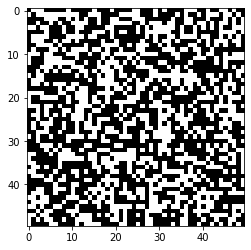

In [14]:
plt.imshow(I.data.numpy()[0,0,:,:], cmap='gray')
plt.show()

In [15]:
# %% convert to pytorch code
aa = np.rot90(np.rot90(a)).copy()
inputs = torch.from_numpy(aa.reshape([1, 1, size[0], size[1]]))
# inputs = torch.from_numpy(a.reshape([1, 1, size[0], size[1]]))
inputs = inputs.type(torch.FloatTensor)
inputs = Variable(inputs)
weights = torch.from_numpy(e.reshape([1,1,d.shape[0], d.shape[1]]))
weights = weights.type(torch.FloatTensor)
weights = Variable(weights)
bias = Variable(torch.tensor([-10.0]))
outputs = F.conv_transpose2d(weights, inputs, bias, padding=0)
# outputs = F.conv2d(inputs, weights, bias, padding=5)
# print(outputs.size())
outputs = F.relu(outputs)
outputs = torch.mean(outputs, dim=(1,2,3))
outputs = torch.mean(outputs)
print(outputs)

tensor(0.0327)


In [24]:
outputs.requires_grad = False
weights.requires_grad = False
bias.requires_grad = False
I = Variable(torch.rand([1, 1, size[0], size[1]]), requires_grad=True)
init_I = I.detach().data
# I = Variable(I, requires_grad=True)
for i in range(100):
    out = F.conv_transpose2d(weights, I, bias, padding=0, stride=1)
    out = F.relu(out)
    loss1 = ((out.mean()-outputs)**2).mean()
    loss2 = (I - torch.square(I)).mean()
    loss = loss1
    grads = torch.autograd.grad(loss1, I)
    print(loss)
    with torch.no_grad():
        if I.grad is None:
            I.grad = grads[0].detach()
        else:
            I.grad.fill_(grads[0].detach())
    I = I - 10000 * I.grad
    I = torch.clamp(I, 0, 1)

tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0011, grad_fn=<MeanBackward0>)


/opt/anaconda3/envs/py3_ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  app.launch_new_instance()


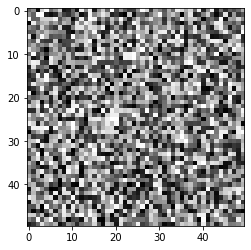

In [25]:
plt.imshow(I.data.numpy()[0,0,:,:], cmap='gray')
plt.show()

In [24]:
a = np.arange(4).reshape([2,2])
b = np.arange(9).reshape([3,3])
bb = np.rot90(np.rot90(b)).copy()

In [27]:
c = torch.from_numpy(a.reshape([1, 1, 2, 2])).type(torch.FloatTensor)
d = torch.from_numpy(b.reshape([1, 1, 3, 3])).type(torch.FloatTensor)
dd = torch.from_numpy(bb.reshape([1, 1, 3, 3])).type(torch.FloatTensor)
e = F.conv2d(d, c, padding=1)
f = F.conv_transpose2d(c, dd)

In [28]:
e, f

(tensor([[[[ 0.,  3.,  8.,  4.],
           [ 9., 19., 25., 10.],
           [21., 37., 43., 16.],
           [ 6.,  7.,  8.,  0.]]]]),
 tensor([[[[ 0.,  8.,  7.,  6.],
           [16., 43., 37., 21.],
           [10., 25., 19.,  9.],
           [ 4.,  8.,  3.,  0.]]]]))